🚀 LISTA (Learned ISTA) Implementation
📖 Based on Gregor & LeCun papers
--------------------------------------------------
Choose training option:
1. Quick test (10 epochs)
2. Standard training (50 epochs)
3. Extended training (100 epochs)


Enter choice (1/2/3):  1


🔬 LISTA TRAINING & TESTING PIPELINE
📚 Based on: Learning fast approximations of sparse coding (Gregor & LeCun)
💻 Using device: cuda

📂 Creating data loaders...
    📊 Train samples: 21920
    📊 Test samples: 230

🏗️ Creating LISTA model...
🔧 Initializing LISTA weights (CORRECTED)...
    ✓ conv_lista.soft_threshold: γ = 0.01
    ✓ conv_lista.G: Kaiming initialization
    ✓ conv_lista.T_layers.0: Kaiming initialization
    ✓ conv_lista.T_layers.1: Kaiming initialization
    ✓ conv_lista.T_layers.2: Kaiming initialization
    ✓ conv_lista.V_layers.0: Kaiming initialization
    ✓ conv_lista.V_layers.1: Kaiming initialization
    ✓ conv_lista.V_layers.2: Kaiming initialization
    ✓ reconstruction_dict: Kaiming initialization
✅ LISTA initialization completed!
    📊 Total parameters: 1,210,946
    💾 Model size: 4.8MB

🚀 Starting LISTA Training (CORRECTED)
📊 Training setup:
   - Model: Convolutional LISTA (ACSC)
   - Loss: MSE
   - Optimizer: Adam, lr=1e-3 (INCREASED)
   - Scheduler: ReduceLRO

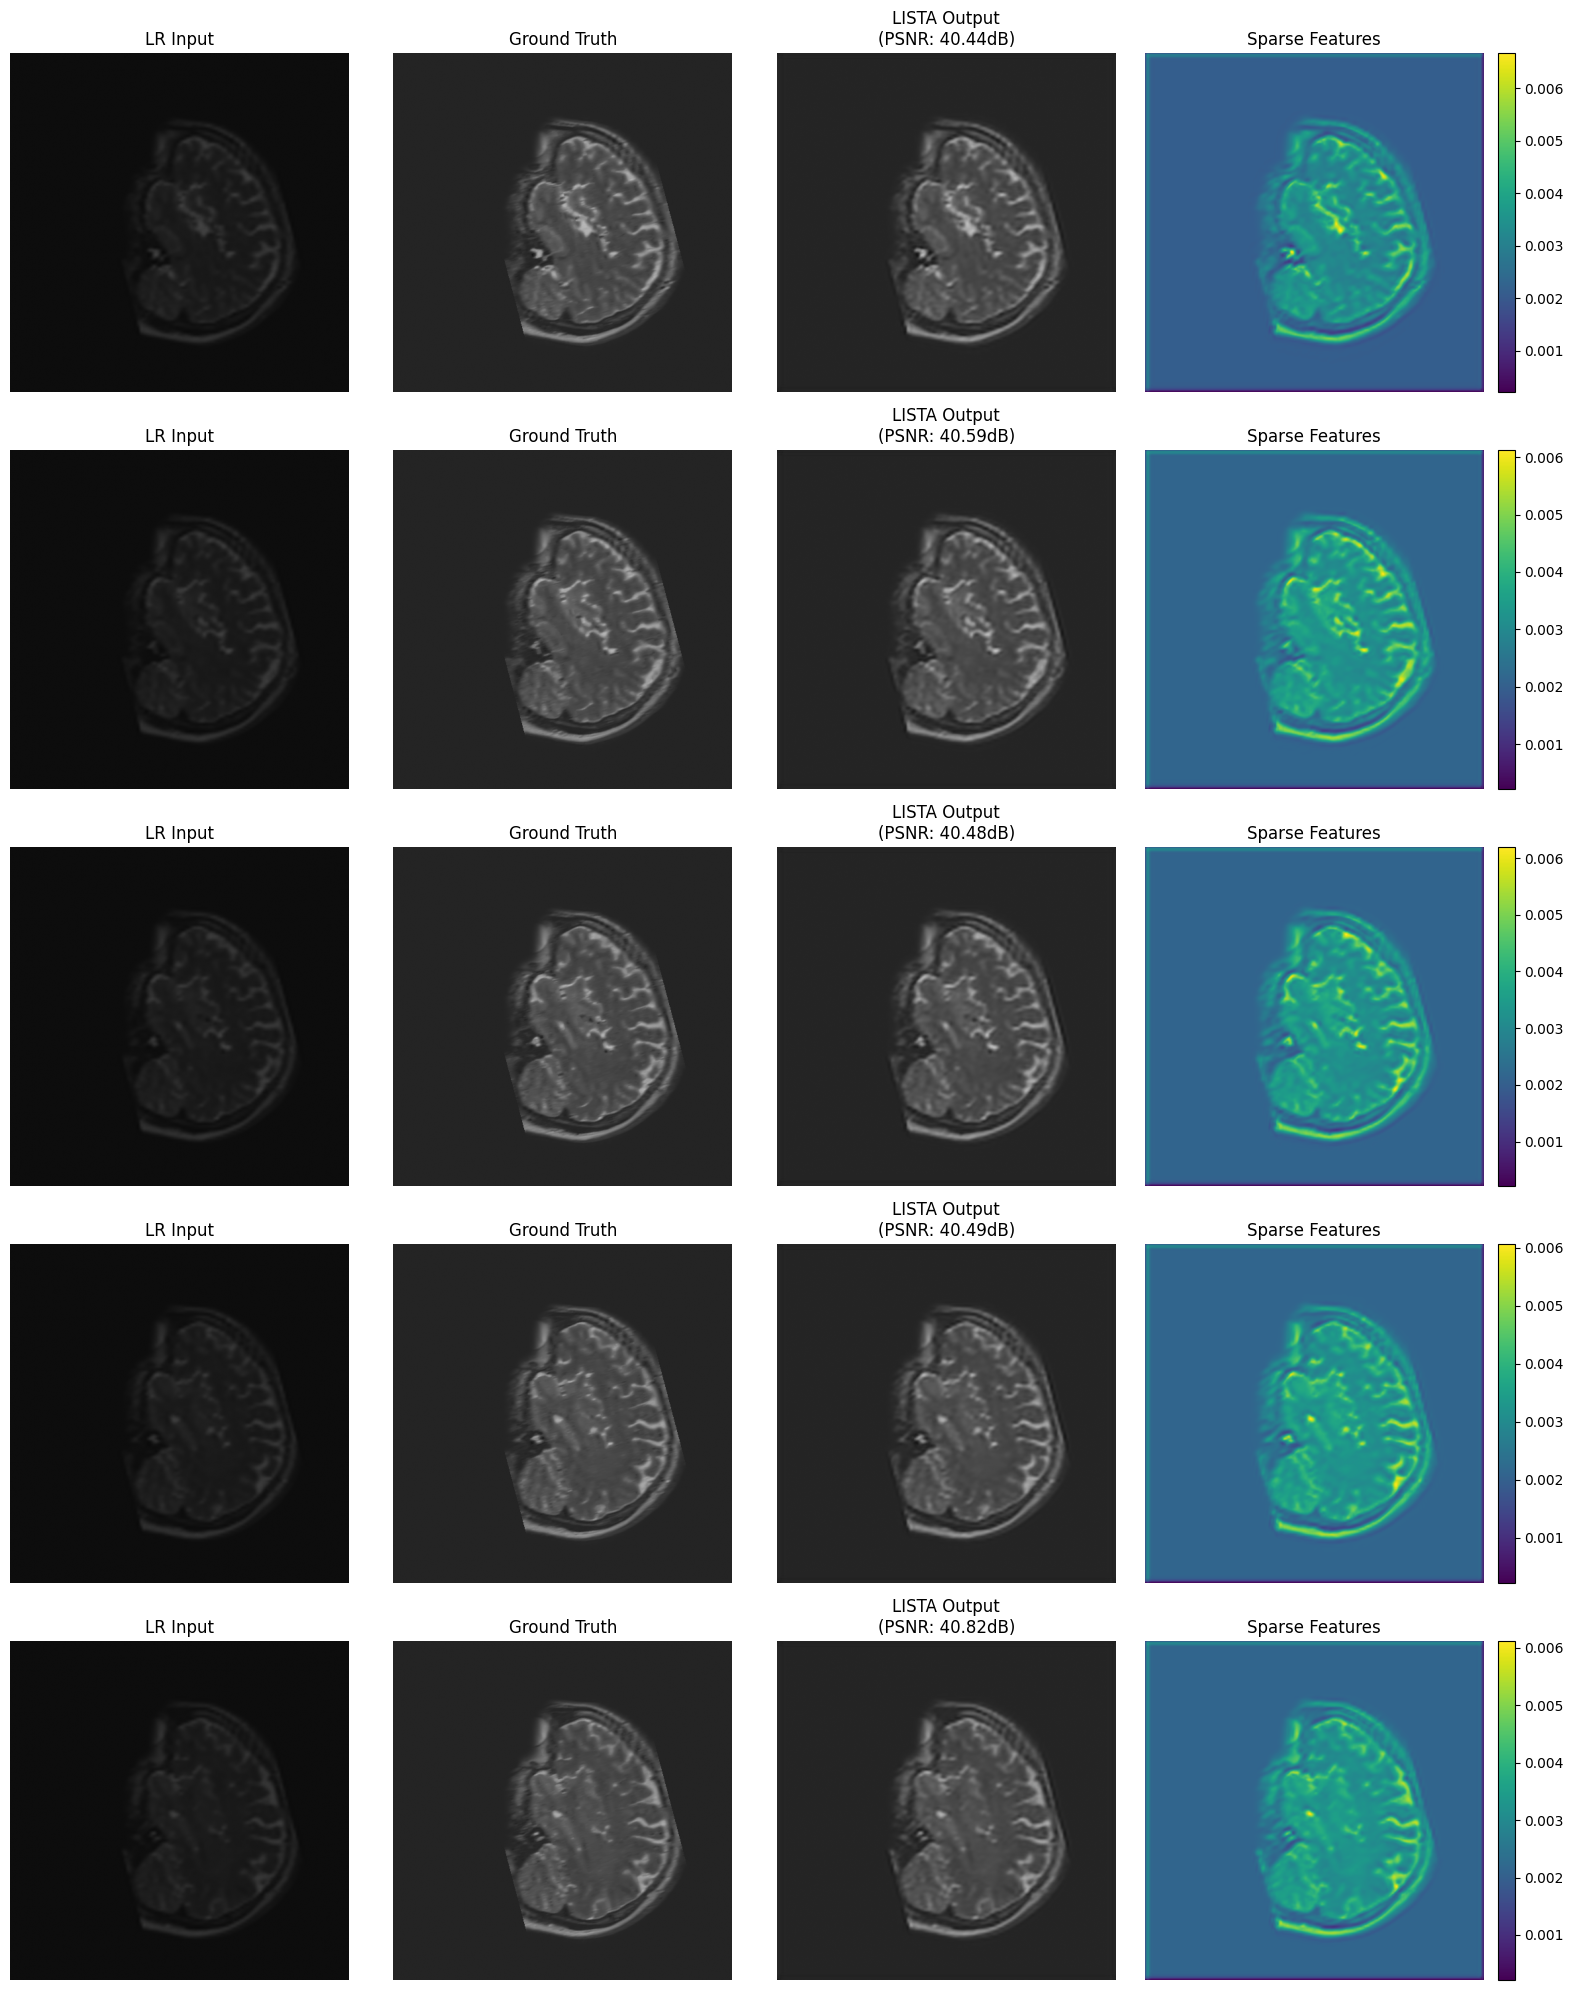

💾 Results saved as 'lista_results.png'

🏁 FINAL SUMMARY:
    🎯 Average PSNR: 38.85dB
    📚 Model: Convolutional LISTA (ACSC)
    ⚙️ Architecture: 3 stages, 64 filters


In [5]:
#!/usr/bin/env python
# coding: utf-8

"""
LISTA (Learned ISTA) Implementation
Based on: "Learning fast approximations of sparse coding" (Gregor & LeCun, 2010)

Εξίσωση από Paper 1 (σελίδα 1, εξίσωση 8):
u^t = φγ(S*u^{t-1} + W*y), u^0 = 0

όπου:
- S = I - (1/L)*D^T*D  
- W = (1/L)*D^T
- φγ: soft thresholding operator
- γ > 0: learnable threshold parameter
"""

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# Χρησιμοποιούμε το ίδιο dataset loader από το LeSITA implementation
#from LESITA_FINAL import MRIDataset, get_dataloader, psnr

# =============================================================================
# MRI DATASET LOADER - EXTRACTED FROM LESITA_FINAL.py
# =============================================================================

import torch
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np

class MRIDataset(Dataset):
    def __init__(self, h5_file, input_key='T2W/LRINPUT', target_key='T2W/TARGET', si_key='T1W/TARGET', augment=False):
        self.h5_file = h5_file
        with h5py.File(h5_file, 'r') as file:
            self.inputs = file[input_key][:]
            self.targets = file[target_key][:]
            self.si = file[si_key][:]

        assert len(self.inputs) == len(self.targets) == len(self.si), "Mismatch in dataset lengths."
        self.augment = augment

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_img = self.inputs[idx].astype(np.float32) / 255.0
        target_img = self.targets[idx].astype(np.float32) / 255.0
        si_img = self.si[idx].astype(np.float32) / 255.0

        input_img = torch.from_numpy(input_img).unsqueeze(0)  # [1, H, W]
        target_img = torch.from_numpy(target_img).unsqueeze(0)
        si_img = torch.from_numpy(si_img).unsqueeze(0)

        if self.augment:
            if torch.rand(1) > 0.5:
                input_img = torch.flip(input_img, [2])
                target_img = torch.flip(target_img, [2])
                si_img = torch.flip(si_img, [2])
            if torch.rand(1) > 0.5:
                input_img = torch.flip(input_img, [1])
                target_img = torch.flip(target_img, [1])
                si_img = torch.flip(si_img, [1])
            if torch.rand(1) > 0.5:
                k = torch.randint(0, 4, (1,))
                input_img = torch.rot90(input_img, k.item(), [1, 2])
                target_img = torch.rot90(target_img, k.item(), [1, 2])
                si_img = torch.rot90(si_img, k.item(), [1, 2])

        return input_img, target_img, si_img

def get_dataloader(h5_file, batch_size=64, shuffle=True, augment=False):
    dataset = MRIDataset(h5_file, augment=augment)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

def psnr(y_true, y_pred, max_val=1.0):
    """
    PSNR metric όπως χρησιμοποιείται στα papers
    """
    mse = torch.mean((y_true - y_pred) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(max_val / torch.sqrt(mse))
# =============================================================================
# SOFT THRESHOLDING OPERATOR (φγ)
# =============================================================================

class SoftThresholding(nn.Module):
    """
    Soft Thresholding Operator από Papers 1 & 2
    
    Εξίσωση (7) από Paper 1: φγ(vi) = sign(vi) * max{0, |vi| − γ}
    Εξίσωση (9) από Paper 2: φγ(vi) = sign(vi) * max{0, |vi| − γ}
    
    Το γ είναι learnable parameter
    """
    def __init__(self, threshold=0.1):
        super(SoftThresholding, self).__init__()
        # Learnable threshold parameter γ
        self.threshold = nn.Parameter(torch.tensor(threshold, dtype=torch.float32))
        
    def forward(self, x):
        """
        Υλοποίηση της εξίσωσης: φγ(vi) = sign(vi) * max{0, |vi| − γ}
        """
        return torch.sign(x) * torch.clamp(torch.abs(x) - self.threshold, min=0.0)

# =============================================================================
# LISTA MODEL 
# =============================================================================

class LISTA(nn.Module):
    """
    LISTA (Learned ISTA) Model από Papers 1 & 2
    
    Εξίσωση (8) από Paper 1: u^t = φγ(S*u^{t-1} + W*y), u^0 = 0
    Εξίσωση (10) από Paper 2: u^t = φγ(S*u^{t-1} + W*y), u^0 = 0
    
    όπου:
    - S ∈ R^{m×m}: learnable matrix (αρχικά S = I - (1/L)*D^T*D)  
    - W ∈ R^{m×n}: learnable matrix (αρχικά W = (1/L)*D^T)
    - γ > 0: learnable threshold parameter
    """
    
    def __init__(self, input_size, sparse_size, num_stages=3, threshold=0.1):
        """
        Args:
            input_size: διάσταση εισόδου (n) - μέγεθος vectorized image
            sparse_size: διάσταση sparse representation (m) 
            num_stages: αριθμός LISTA iterations (T)
            threshold: αρχική τιμή του γ
        """
        super(LISTA, self).__init__()
        
        self.input_size = input_size      # n (από papers)
        self.sparse_size = sparse_size    # m (από papers) 
        self.num_stages = num_stages      # T (από papers)
        
        # Soft thresholding operator με learnable threshold γ
        self.soft_threshold = SoftThresholding(threshold)
        
        # Learnable matrices S και W για κάθε stage
        # Από Paper 1: "The parameters S ∈ R^{m×m}, W ∈ R^{m×n} and γ > 0 of LISTA can be learned from data"
        self.S_layers = nn.ModuleList([
            nn.Linear(sparse_size, sparse_size, bias=False) 
            for _ in range(num_stages)
        ])
        
        self.W_layers = nn.ModuleList([
            nn.Linear(input_size, sparse_size, bias=False)
            for _ in range(num_stages)
        ])
        
    def forward(self, y):
        """
        y: input signal/image (vectorized) - διάσταση [batch_size, input_size]
        
        Returns: sparse codes u - διάσταση [batch_size, sparse_size]
        
        Υλοποιεί την εξίσωση: u^t = φγ(S*u^{t-1} + W*y), u^0 = 0
        """
        batch_size = y.shape[0]
        device = y.device
        
        # Αρχικοποίηση: u^0 = 0 (από Papers)
        u = torch.zeros(batch_size, self.sparse_size, device=device, dtype=y.dtype)
        
        # LISTA iterations για num_stages
        for t in range(self.num_stages):
            # u^t = φγ(S*u^{t-1} + W*y)
            Su = self.S_layers[t](u)          # S * u^{t-1}
            Wy = self.W_layers[t](y)          # W * y
            u = self.soft_threshold(Su + Wy)  # φγ(S*u^{t-1} + W*y)
            
        return u

# =============================================================================
# CONVOLUTIONAL LISTA (ACSC από το Paper 2)
# =============================================================================

class ConvLISTA(nn.Module):
    """
    Convolutional LISTA = ACSC (Approximate Convolutional Sparse Coding)
    
    Εξίσωση (9) από Paper 2: U^t = φγ(U^{t-1} - T ∗ V ∗ U^{t-1} + G ∗ Y)
    Εξίσωση (11) από Paper 2: U^t = φγ(U^{t-1} - T ∗ V ∗ U^{t-1} + G ∗ Y)
    
    όπου:
    - T, V, G: learnable convolutional parameters
    - φγ: soft thresholding operator
    """
    
    def __init__(self, num_stages=3, num_filters=64, kernel_size=7, threshold=0.1):
        super(ConvLISTA, self).__init__()
        
        self.num_stages = num_stages
        
        # Soft thresholding operator με learnable threshold γ
        self.soft_threshold = SoftThresholding(threshold)
        
        # G parameter: μετατρέπει την εικόνα Y (1 channel) σε num_filters channels
        # Από Paper 2: G ∗ Y term
        self.G = nn.Conv2d(1, num_filters, kernel_size, padding=kernel_size//2)
        
        # T parameters για κάθε stage
        # Από Paper 2: T ∗ V ∗ U^{t-1} term
        self.T_layers = nn.ModuleList([
            nn.Conv2d(num_filters, num_filters, kernel_size, padding=kernel_size//2)
            for _ in range(num_stages)
        ])
        
        # V parameters για κάθε stage  
        self.V_layers = nn.ModuleList([
            nn.Conv2d(num_filters, num_filters, kernel_size, padding=kernel_size//2)
            for _ in range(num_stages)
        ])
        
    def forward(self, Y):
        """
        Y: input image - διάσταση [batch_size, 1, H, W]
        
        Returns: sparse feature maps U - διάσταση [batch_size, num_filters, H, W]
        
        Υλοποιεί την εξίσωση: U^t = φγ(U^{t-1} - T ∗ V ∗ U^{t-1} + G ∗ Y)
        """
        batch_size, channels, height, width = Y.shape
        device = Y.device
        
        # Αρχικοποίηση: U^0 = 0 (implied από τα papers)
        U = torch.zeros(batch_size, self.G.out_channels, height, width, 
                       device=device, dtype=Y.dtype)
        
        # Υπολογισμός G ∗ Y μία φορά (δεν αλλάζει στις επαναλήψεις)
        GY = self.G(Y)
        
        # Convolutional LISTA iterations
        for t in range(self.num_stages):
            # T ∗ V ∗ U^{t-1}
            VU = self.V_layers[t](U)
            TVU = self.T_layers[t](VU)
            
            # U^t = φγ(U^{t-1} - T ∗ V ∗ U^{t-1} + G ∗ Y)
            U = self.soft_threshold(U - TVU + GY)
            
        return U

# =============================================================================
# END-TO-END RECONSTRUCTION MODEL
# =============================================================================

class LISTAReconstruction(nn.Module):
    """
    Πλήρες LISTA-based reconstruction model
    
    Αρχιτεκτονική:
    1. Convolutional LISTA (ACSC) για sparse feature extraction
    2. Reconstruction dictionary για HR image synthesis
    """
    
    def __init__(self, num_stages=3, num_filters=64, kernel_size=7, threshold=0.1):
        super(LISTAReconstruction, self).__init__()
        
        # Convolutional LISTA encoder
        self.conv_lista = ConvLISTA(
            num_stages=num_stages,
            num_filters=num_filters, 
            kernel_size=kernel_size,
            threshold=threshold
        )
        
        # Reconstruction dictionary: μετατρέπει sparse features σε HR image
        self.reconstruction_dict = nn.Conv2d(
            num_filters, 1, kernel_size, padding=kernel_size//2
        )
        
        # Αρχικοποίηση παραμέτρων
        self._initialize_weights()
        
    def _initialize_weights(self):
        """
        ΔΙΟΡΘΩΜΕΝΗ Αρχικοποίηση παραμέτρων για καλύτερη convergence
        """
        print("🔧 Initializing LISTA weights (CORRECTED)...")
        
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                # ΔΙΟΡΘΩΣΗ: Xavier/Kaiming initialization αντί για μικρό Gaussian
                # Αυτό βοηθάει με gradient flow και convergence
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
                print(f"    ✓ {name}: Kaiming initialization")
                    
            elif isinstance(module, SoftThresholding):
                # Μικρότερο threshold για καλύτερη αρχή
                with torch.no_grad():
                    module.threshold.data.fill_(0.01)  # ΔΙΟΡΘΩΣΗ: 0.01 αντί για 0.1
                print(f"    ✓ {name}: γ = 0.01")
                
        print("✅ LISTA initialization completed!")
        
    def forward(self, y):
        """
        y: LR input image - διάσταση [batch_size, 1, H, W]
        
        Returns: reconstructed HR image - διάσταση [batch_size, 1, H, W]
        """
        # Step 1: Sparse feature extraction με Convolutional LISTA
        sparse_features = self.conv_lista(y)
        
        # Step 2: Reconstruction με learned dictionary
        reconstructed = self.reconstruction_dict(sparse_features)
        
        return reconstructed, sparse_features

# =============================================================================
# TRAINING SETUP
# =============================================================================

class LISTATrainer:
    """
    Training setup για LISTA model
    """
    
    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device
        
        # Loss function: MSE
        self.criterion = nn.MSELoss()
        
        # ΔΙΟΡΘΩΣΗ: Μεγαλύτερο learning rate για καλύτερη convergence
        # Όταν τα weights είναι μικρά, χρειάζεται πιο aggressive learning
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)  # ΑΛΛΑΓΗ: 1e-3 αντί για 1e-4
        
        # ΠΡΟΣΘΗΚΗ: Learning rate scheduler για καλύτερη σταθερότητα
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='max', factor=0.5, patience=5
        )
        
    def train_epoch(self, dataloader):
        """Training για ένα epoch"""
        self.model.train()
        total_loss = 0.0
        total_psnr = 0.0
        
        for batch_idx, (x_lr, x_hr, x_si) in enumerate(dataloader):
            # Μεταφορά στη GPU/CPU
            x_lr = x_lr.to(self.device)  # LR input
            x_hr = x_hr.to(self.device)  # HR target (ground truth)
            # Σημείωση: x_si (side information) δεν χρησιμοποιείται στο LISTA
            
            # Forward pass
            self.optimizer.zero_grad()
            pred_hr, sparse_features = self.model(x_lr)
            
            # Loss computation
            loss = self.criterion(pred_hr, x_hr)
            
            # Backward pass
            loss.backward()
            self.optimizer.step()
            
            # Metrics
            total_loss += loss.item()
            
            with torch.no_grad():
                batch_psnr = psnr(x_hr, pred_hr)
                total_psnr += batch_psnr.item() if torch.isfinite(batch_psnr) else 0.0
        
        avg_loss = total_loss / len(dataloader)
        avg_psnr = total_psnr / len(dataloader)
        
        return avg_loss, avg_psnr
    
    def validate(self, dataloader):
        """Validation loop"""
        self.model.eval()
        total_loss = 0.0
        total_psnr = 0.0
        
        with torch.no_grad():
            for x_lr, x_hr, x_si in dataloader:
                x_lr = x_lr.to(self.device)
                x_hr = x_hr.to(self.device)
                
                pred_hr, _ = self.model(x_lr)
                loss = self.criterion(pred_hr, x_hr)
                
                total_loss += loss.item()
                batch_psnr = psnr(x_hr, pred_hr)
                total_psnr += batch_psnr.item() if torch.isfinite(batch_psnr) else 0.0
        
        avg_loss = total_loss / len(dataloader)
        avg_psnr = total_psnr / len(dataloader)
        
        return avg_loss, avg_psnr
    
    def train(self, train_loader, val_loader, epochs=100, checkpoint_path="lista_best.pt"):
        """Πλήρης training loop με ΔΙΟΡΘΩΣΕΙΣ"""
        print("🚀 Starting LISTA Training (CORRECTED)")
        print(f"📊 Training setup:")
        print(f"   - Model: Convolutional LISTA (ACSC)")
        print(f"   - Loss: MSE")
        print(f"   - Optimizer: Adam, lr=1e-3 (INCREASED)")  # ΔΙΟΡΘΩΣΗ
        print(f"   - Scheduler: ReduceLROnPlateau")  # ΠΡΟΣΘΗΚΗ
        print(f"   - Epochs: {epochs}")
        print(f"   - Device: {self.device}")
        print("-" * 60)
        
        best_psnr = 0.0
        patience_counter = 0
        max_patience = 10  # ΠΡΟΣΘΗΚΗ: Early stopping
        
        for epoch in range(epochs):
            # Training
            train_loss, train_psnr = self.train_epoch(train_loader)
            
            # Validation
            val_loss, val_psnr = self.validate(val_loader)
            
            # ΠΡΟΣΘΗΚΗ: Learning rate scheduling
            self.scheduler.step(val_psnr)
            
            # Logging
            print(f"📈 Epoch [{epoch+1:3d}/{epochs}] | "
                  f"Train: Loss={train_loss:.6f}, PSNR={train_psnr:.2f}dB | "
                  f"Val: Loss={val_loss:.6f}, PSNR={val_psnr:.2f}dB")
            
            # Save best model
            if val_psnr > best_psnr:
                best_psnr = val_psnr
                patience_counter = 0  # Reset patience
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'best_psnr': best_psnr,
                    'train_loss': train_loss,
                    'val_loss': val_loss
                }, checkpoint_path)
                print(f"💾 Saved best model (PSNR: {best_psnr:.2f}dB)")
            else:
                patience_counter += 1
                
            # ΠΡΟΣΘΗΚΗ: Early stopping
            if patience_counter >= max_patience:
                print(f"🛑 Early stopping after {patience_counter} epochs without improvement")
                break
        
        print("✅ Training completed!")
        print(f"🏆 Best validation PSNR: {best_psnr:.2f}dB")
        
        return best_psnr

# =============================================================================
# TESTING & VISUALIZATION
# =============================================================================

def test_lista_model(model_path, test_loader, device):
    """Testing και evaluation του LISTA model"""
    
    print("🧪 Starting LISTA Model Testing")
    print("=" * 50)
    
    # Φόρτωση του καλύτερου μοντέλου
    model = LISTAReconstruction()
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    print(f"📁 Loaded model from: {model_path}")
    print(f"🏆 Best training PSNR: {checkpoint['best_psnr']:.2f}dB")
    print("-" * 50)
    
    # Testing metrics
    total_psnr = 0.0
    total_samples = 0
    results = []
    
    with torch.no_grad():
        for batch_idx, (x_lr, x_hr, x_si) in enumerate(test_loader):
            x_lr = x_lr.to(device)  # LR input
            x_hr = x_hr.to(device)  # HR ground truth
            
            # Inference
            pred_hr, sparse_features = model(x_lr)
            
            # PSNR για κάθε εικόνα στο batch
            for i in range(x_lr.shape[0]):
                img_psnr = psnr(x_hr[i:i+1], pred_hr[i:i+1]).item()
                total_psnr += img_psnr
                total_samples += 1
                
                # Αποθήκευση για visualization (πρώτες 5 εικόνες)
                if len(results) < 5:
                    results.append({
                        'lr': x_lr[i].cpu(),
                        'hr_gt': x_hr[i].cpu(), 
                        'hr_pred': pred_hr[i].cpu(),
                        'sparse_features': sparse_features[i].cpu(),
                        'psnr': img_psnr
                    })
            
            if batch_idx % 5 == 0:
                print(f"   📊 Processed batch {batch_idx+1}/{len(test_loader)}")
    
    # Τελικά αποτελέσματα
    avg_psnr = total_psnr / total_samples
    print(f"\n🎯 ΤΕΛΙΚΑ ΑΠΟΤΕΛΕΣΜΑΤΑ:")
    print(f"    📊 Average PSNR: {avg_psnr:.2f}dB")
    print(f"    📈 Total samples: {total_samples}")
    
    return results, avg_psnr

def visualize_lista_results(results):
    """Visualization των αποτελεσμάτων του LISTA"""
    
    print("🎨 Creating LISTA visualization...")
    
    fig, axes = plt.subplots(len(results), 4, figsize=(16, 4*len(results)))
    if len(results) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, result in enumerate(results):
        # Μετατροπή σε numpy arrays
        lr = result['lr'][0].numpy()
        hr_gt = result['hr_gt'][0].numpy() 
        hr_pred = result['hr_pred'][0].detach().numpy()
        sparse_features = result['sparse_features'].mean(dim=0).numpy()  # Mean across channels
        
        # Error map
        error_map = np.abs(hr_gt - hr_pred)
        
        # Plots
        axes[idx, 0].imshow(lr, cmap='gray', vmin=0, vmax=1)
        axes[idx, 0].set_title(f'LR Input', fontsize=12)
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(hr_gt, cmap='gray', vmin=0, vmax=1)
        axes[idx, 1].set_title(f'Ground Truth', fontsize=12)
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(hr_pred, cmap='gray', vmin=0, vmax=1)
        axes[idx, 2].set_title(f'LISTA Output\n(PSNR: {result["psnr"]:.2f}dB)', fontsize=12)
        axes[idx, 2].axis('off')
        
        # Sparse features visualization
        im = axes[idx, 3].imshow(sparse_features, cmap='viridis')
        axes[idx, 3].set_title(f'Sparse Features', fontsize=12)
        axes[idx, 3].axis('off')
        plt.colorbar(im, ax=axes[idx, 3], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.savefig('lista_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("💾 Results saved as 'lista_results.png'")

# =============================================================================
# MAIN PIPELINE FUNCTION
# =============================================================================

def main_lista_pipeline(epochs=50):
    """Πλήρης LISTA training και testing pipeline"""
    
    print("🔬 LISTA TRAINING & TESTING PIPELINE")
    print("📚 Based on: Learning fast approximations of sparse coding (Gregor & LeCun)")
    print("="*70)
    
    try:
        # Setup device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"💻 Using device: {device}")
        
        # Data paths (χρησιμοποιούμε τα ίδια με το LeSITA)
        train_path = r"D:\Diploma Thesis\MICCAI DATASETS\LRx4_MStrain_flair_t1w_t2w_44_unnormalized.h5py"
        test_path = r"D:\Diploma Thesis\MICCAI DATASETS\LRx4_MStest_flair_t1w_t2w_unnormalized.h5py"
        
        # Data loaders
        print("\n📂 Creating data loaders...")
        train_loader = get_dataloader(train_path, batch_size=32, shuffle=True, augment=True)
        test_loader = get_dataloader(test_path, batch_size=8, shuffle=False, augment=False)
        
        print(f"    📊 Train samples: {len(train_loader.dataset)}")
        print(f"    📊 Test samples: {len(test_loader.dataset)}")
        
        # Model creation
        print("\n🏗️ Creating LISTA model...")
        model = LISTAReconstruction(
            num_stages=3,        # 3 unfolding stages
            num_filters=64,      # 64 sparse feature maps
            kernel_size=7,       # 7x7 kernels
            threshold=0.1        # Initial γ = 0.1
        )
        
        # Model info
        total_params = sum(p.numel() for p in model.parameters())
        print(f"    📊 Total parameters: {total_params:,}")
        print(f"    💾 Model size: {total_params * 4 / 1e6:.1f}MB")
        
        # Training
        print(f"\n{'='*70}")
        trainer = LISTATrainer(model, device)
        best_psnr = trainer.train(train_loader, test_loader, epochs=epochs, 
                                 checkpoint_path="lista_best.pt")
        
        # Testing
        print(f"\n{'='*70}")
        results, avg_psnr = test_lista_model("lista_best.pt", test_loader, device)
        
        # Visualization
        print(f"\n{'='*70}")
        visualize_lista_results(results)
        
        # Final summary
        print(f"\n🏁 FINAL SUMMARY:")
        print(f"    🎯 Average PSNR: {avg_psnr:.2f}dB")
        print(f"    📚 Model: Convolutional LISTA (ACSC)")
        print(f"    ⚙️ Architecture: {model.conv_lista.num_stages} stages, {model.conv_lista.G.out_channels} filters")
        
        return model, avg_psnr
        
    except Exception as e:
        print(f"❌ Error: {e}")
        print(f"🔧 Make sure your .h5 files exist and paths are correct")

# =============================================================================
# QUICK START
# =============================================================================

if __name__ == "__main__":
    print("🚀 LISTA (Learned ISTA) Implementation")
    print("📖 Based on Gregor & LeCun papers")
    print("-" * 50)
    
    print("Choose training option:")
    print("1. Quick test (10 epochs)")
    print("2. Standard training (50 epochs)")
    print("3. Extended training (100 epochs)")
    
    choice = input("Enter choice (1/2/3): ").strip()
    
    if choice == "1":
        main_lista_pipeline(epochs=10)
    elif choice == "2":  
        main_lista_pipeline(epochs=50)
    elif choice == "3":
        main_lista_pipeline(epochs=100)
    else:
        print("🔄 Running default (50 epochs)...")
        main_lista_pipeline(epochs=50)

🚀 LISTA (Learned ISTA) Implementation
📖 Based on Gregor & LeCun papers
--------------------------------------------------
Choose training option:
1. Quick test (10 epochs)
2. Standard training (50 epochs)
3. Extended training (100 epochs)


Enter choice (1/2/3):  1


🔬 LISTA TRAINING & TESTING PIPELINE
📚 Based on: Learning fast approximations of sparse coding (Gregor & LeCun)
💻 Using device: cuda

📂 Creating data loaders...
    📊 Train samples: 21920
    📊 Test samples: 230

🏗️ Creating LISTA model...
🔧 Initializing LISTA weights (CORRECTED)...
    ✓ conv_lista.soft_threshold: γ = 0.01
    ✓ conv_lista.G: Kaiming initialization
    ✓ conv_lista.T_layers.0: Kaiming initialization
    ✓ conv_lista.T_layers.1: Kaiming initialization
    ✓ conv_lista.T_layers.2: Kaiming initialization
    ✓ conv_lista.V_layers.0: Kaiming initialization
    ✓ conv_lista.V_layers.1: Kaiming initialization
    ✓ conv_lista.V_layers.2: Kaiming initialization
    ✓ reconstruction_dict: Kaiming initialization
✅ LISTA initialization completed!
    📊 Total parameters: 2,133,077
    💾 Model size: 8.5MB

🚀 Starting LISTA Training (CORRECTED)
📊 Training setup:
   - Model: Convolutional LISTA (ACSC)
   - Loss: MSE
   - Optimizer: Adam, lr=1e-3 (INCREASED)
   - Scheduler: ReduceLRO

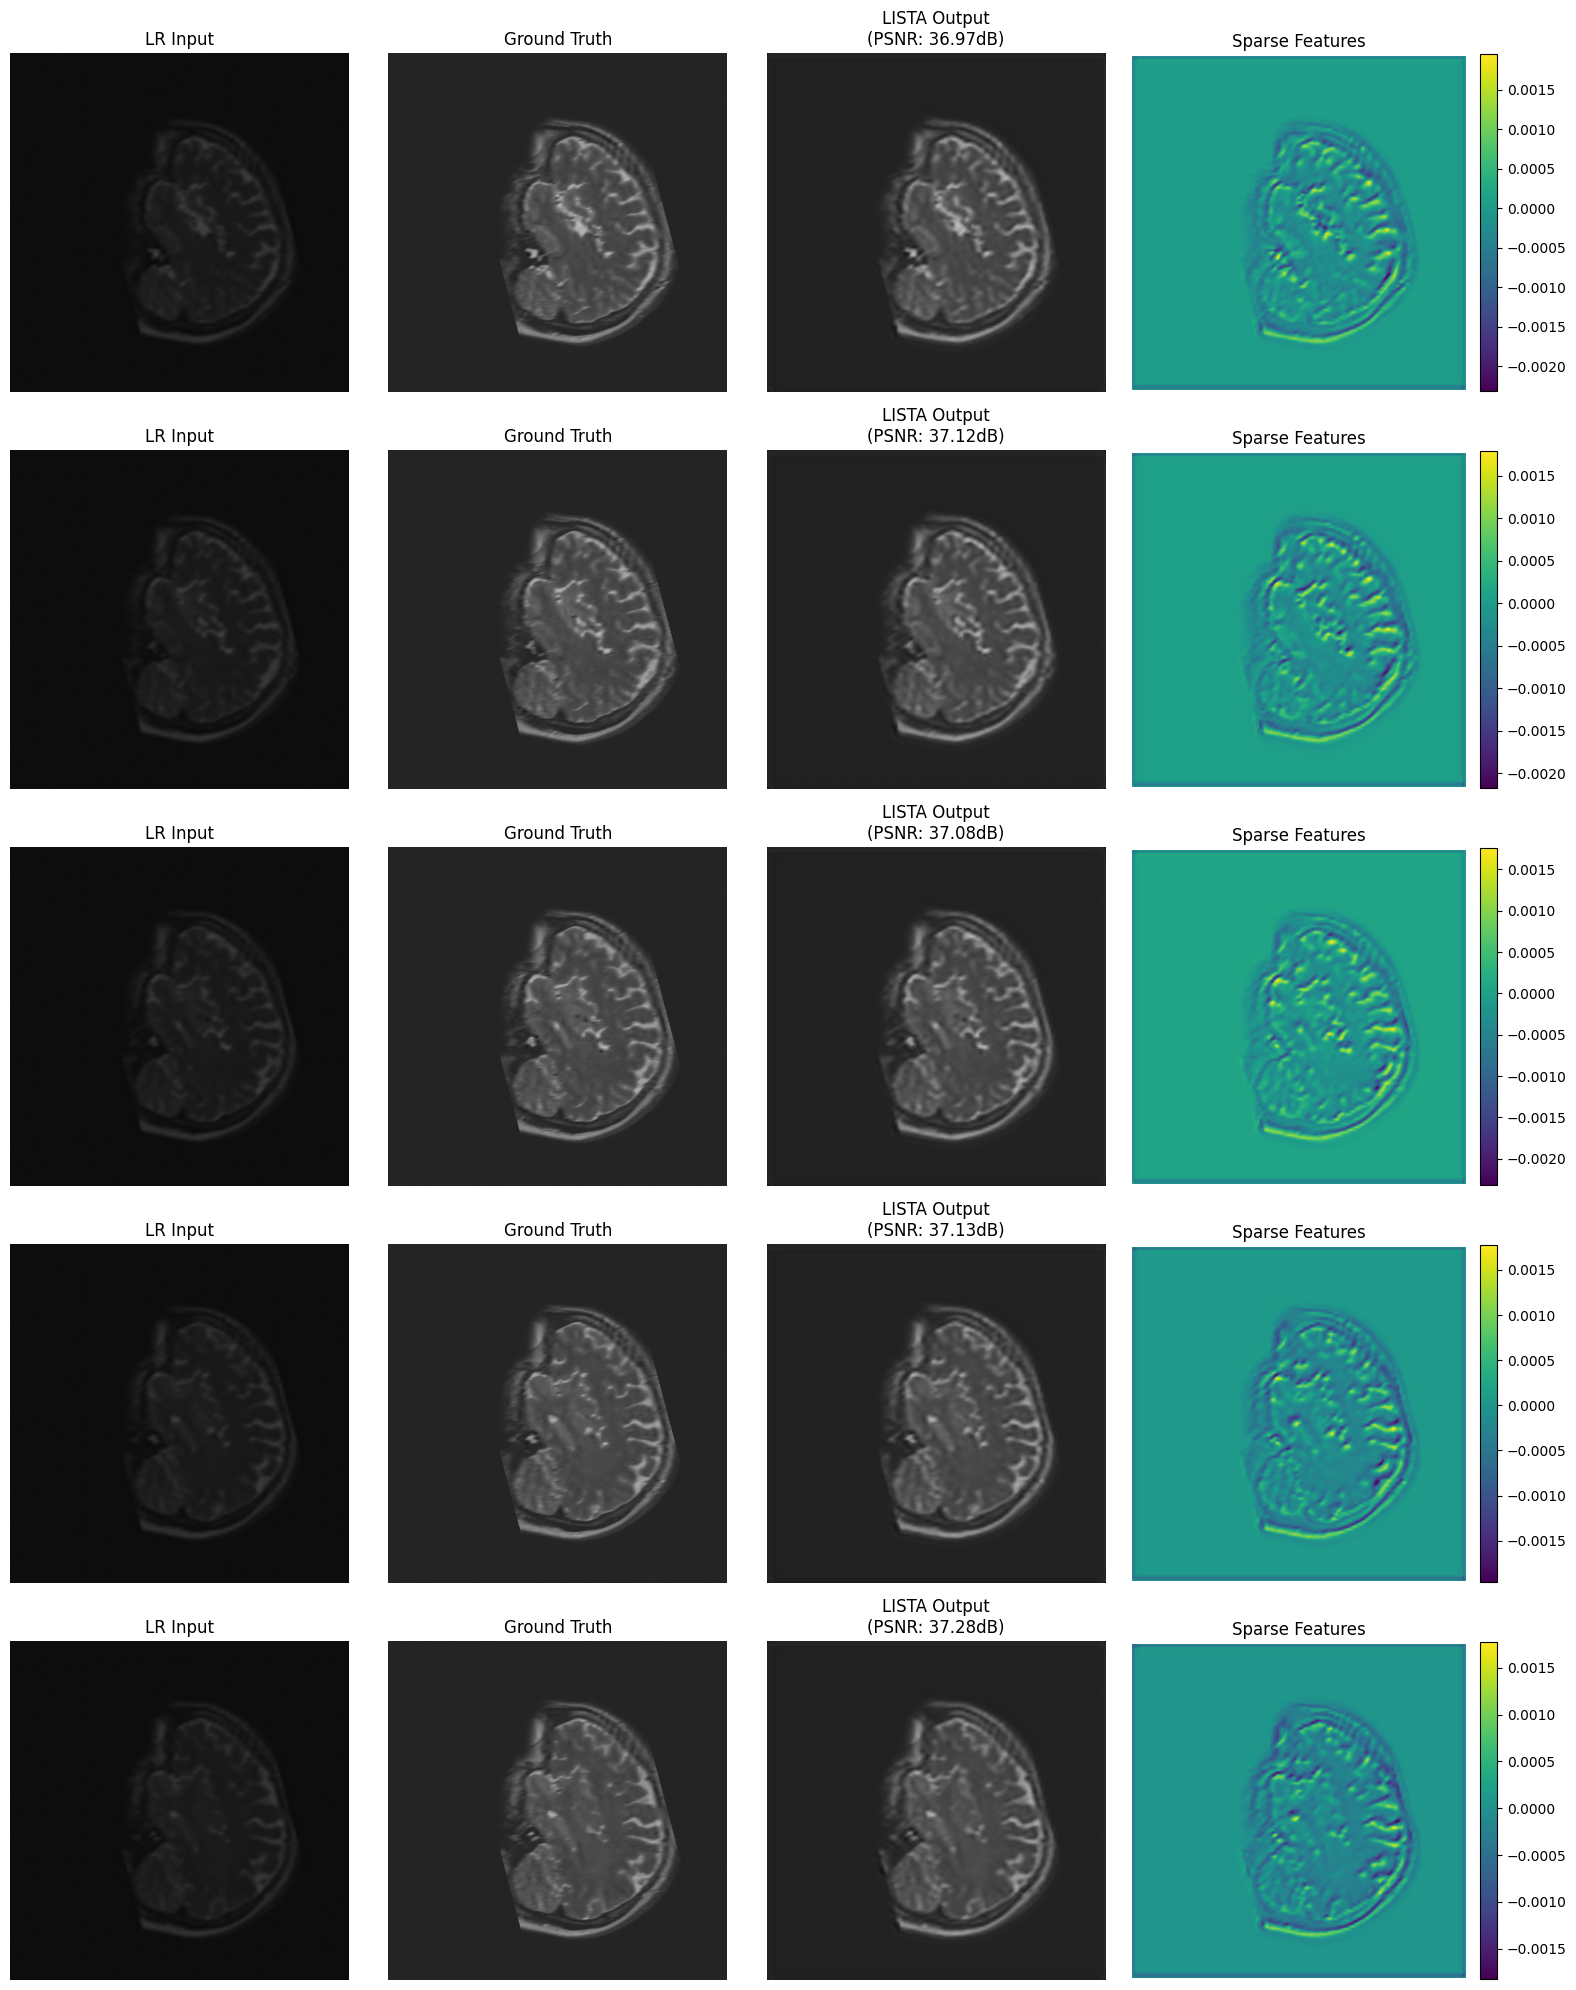

💾 Results saved as 'lista_results.png'

🏁 FINAL SUMMARY:
    🎯 Average PSNR: 35.88dB
    📚 Model: Convolutional LISTA (ACSC)
    ⚙️ Architecture: 3 stages, 85 filters


In [1]:
#!/usr/bin/env python
# coding: utf-8

"""
LISTA (Learned ISTA) Implementation
Based on: "Learning fast approximations of sparse coding" (Gregor & LeCun, 2010)

Εξίσωση από Paper 1 (σελίδα 1, εξίσωση 8):
u^t = φγ(S*u^{t-1} + W*y), u^0 = 0

όπου:
- S = I - (1/L)*D^T*D  
- W = (1/L)*D^T
- φγ: soft thresholding operator
- γ > 0: learnable threshold parameter
"""

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# Χρησιμοποιούμε το ίδιο dataset loader από το LeSITA implementation
#from LESITA_FINAL import MRIDataset, get_dataloader, psnr

# =============================================================================
# MRI DATASET LOADER - EXTRACTED FROM LESITA_FINAL.py
# =============================================================================

import torch
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np

class MRIDataset(Dataset):
    def __init__(self, h5_file, input_key='T2W/LRINPUT', target_key='T2W/TARGET', si_key='T1W/TARGET', augment=False):
        self.h5_file = h5_file
        with h5py.File(h5_file, 'r') as file:
            self.inputs = file[input_key][:]
            self.targets = file[target_key][:]
            self.si = file[si_key][:]

        assert len(self.inputs) == len(self.targets) == len(self.si), "Mismatch in dataset lengths."
        self.augment = augment

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_img = self.inputs[idx].astype(np.float32) / 255.0
        target_img = self.targets[idx].astype(np.float32) / 255.0
        si_img = self.si[idx].astype(np.float32) / 255.0

        input_img = torch.from_numpy(input_img).unsqueeze(0)  # [1, H, W]
        target_img = torch.from_numpy(target_img).unsqueeze(0)
        si_img = torch.from_numpy(si_img).unsqueeze(0)

        if self.augment:
            if torch.rand(1) > 0.5:
                input_img = torch.flip(input_img, [2])
                target_img = torch.flip(target_img, [2])
                si_img = torch.flip(si_img, [2])
            if torch.rand(1) > 0.5:
                input_img = torch.flip(input_img, [1])
                target_img = torch.flip(target_img, [1])
                si_img = torch.flip(si_img, [1])
            if torch.rand(1) > 0.5:
                k = torch.randint(0, 4, (1,))
                input_img = torch.rot90(input_img, k.item(), [1, 2])
                target_img = torch.rot90(target_img, k.item(), [1, 2])
                si_img = torch.rot90(si_img, k.item(), [1, 2])

        return input_img, target_img, si_img

def get_dataloader(h5_file, batch_size=64, shuffle=True, augment=False):
    dataset = MRIDataset(h5_file, augment=augment)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

def psnr(y_true, y_pred, max_val=1.0):
    """
    PSNR metric όπως χρησιμοποιείται στα papers
    """
    mse = torch.mean((y_true - y_pred) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(max_val / torch.sqrt(mse))
# =============================================================================
# SOFT THRESHOLDING OPERATOR (φγ)
# =============================================================================

class SoftThresholding(nn.Module):
    """
    Soft Thresholding Operator από Papers 1 & 2
    
    Εξίσωση (7) από Paper 1: φγ(vi) = sign(vi) * max{0, |vi| − γ}
    Εξίσωση (9) από Paper 2: φγ(vi) = sign(vi) * max{0, |vi| − γ}
    
    Το γ είναι learnable parameter
    """
    def __init__(self, threshold=0.1):
        super(SoftThresholding, self).__init__()
        # Learnable threshold parameter γ
        self.threshold = nn.Parameter(torch.tensor(threshold, dtype=torch.float32))
        
    def forward(self, x):
        """
        Υλοποίηση της εξίσωσης: φγ(vi) = sign(vi) * max{0, |vi| − γ}
        """
        return torch.sign(x) * torch.clamp(torch.abs(x) - self.threshold, min=0.0)

# =============================================================================
# LISTA MODEL 
# =============================================================================

class LISTA(nn.Module):
    """
    LISTA (Learned ISTA) Model από Papers 1 & 2
    
    Εξίσωση (8) από Paper 1: u^t = φγ(S*u^{t-1} + W*y), u^0 = 0
    Εξίσωση (10) από Paper 2: u^t = φγ(S*u^{t-1} + W*y), u^0 = 0
    
    όπου:
    - S ∈ R^{m×m}: learnable matrix (αρχικά S = I - (1/L)*D^T*D)  
    - W ∈ R^{m×n}: learnable matrix (αρχικά W = (1/L)*D^T)
    - γ > 0: learnable threshold parameter
    """
    
    def __init__(self, input_size, sparse_size, num_stages=3, threshold=0.1):
        """
        Args:
            input_size: διάσταση εισόδου (n) - μέγεθος vectorized image
            sparse_size: διάσταση sparse representation (m) 
            num_stages: αριθμός LISTA iterations (T)
            threshold: αρχική τιμή του γ
        """
        super(LISTA, self).__init__()
        
        self.input_size = input_size      # n (από papers)
        self.sparse_size = sparse_size    # m (από papers) 
        self.num_stages = num_stages      # T (από papers)
        
        # Soft thresholding operator με learnable threshold γ
        self.soft_threshold = SoftThresholding(threshold)
        
        # Learnable matrices S και W για κάθε stage
        # Από Paper 1: "The parameters S ∈ R^{m×m}, W ∈ R^{m×n} and γ > 0 of LISTA can be learned from data"
        self.S_layers = nn.ModuleList([
            nn.Linear(sparse_size, sparse_size, bias=False) 
            for _ in range(num_stages)
        ])
        
        self.W_layers = nn.ModuleList([
            nn.Linear(input_size, sparse_size, bias=False)
            for _ in range(num_stages)
        ])
        
    def forward(self, y):
        """
        y: input signal/image (vectorized) - διάσταση [batch_size, input_size]
        
        Returns: sparse codes u - διάσταση [batch_size, sparse_size]
        
        Υλοποιεί την εξίσωση: u^t = φγ(S*u^{t-1} + W*y), u^0 = 0
        """
        batch_size = y.shape[0]
        device = y.device
        
        # Αρχικοποίηση: u^0 = 0 (από Papers)
        u = torch.zeros(batch_size, self.sparse_size, device=device, dtype=y.dtype)
        
        # LISTA iterations για num_stages
        for t in range(self.num_stages):
            # u^t = φγ(S*u^{t-1} + W*y)
            Su = self.S_layers[t](u)          # S * u^{t-1}
            Wy = self.W_layers[t](y)          # W * y
            u = self.soft_threshold(Su + Wy)  # φγ(S*u^{t-1} + W*y)
            
        return u

# =============================================================================
# CONVOLUTIONAL LISTA (ACSC από το Paper 2)
# =============================================================================

class ConvLISTA(nn.Module):
    """
    Convolutional LISTA = ACSC (Approximate Convolutional Sparse Coding)
    
    Εξίσωση (9) από Paper 2: U^t = φγ(U^{t-1} - T ∗ V ∗ U^{t-1} + G ∗ Y)
    Εξίσωση (11) από Paper 2: U^t = φγ(U^{t-1} - T ∗ V ∗ U^{t-1} + G ∗ Y)
    
    όπου:
    - T, V, G: learnable convolutional parameters
    - φγ: soft thresholding operator
    """
    
    def __init__(self, num_stages=3, num_filters=85, kernel_size=7, threshold=0.1):
        super(ConvLISTA, self).__init__()
        
        self.num_stages = num_stages
        
        # Soft thresholding operator με learnable threshold γ
        self.soft_threshold = SoftThresholding(threshold)
        
        # G parameter: μετατρέπει την εικόνα Y (1 channel) σε num_filters channels
        # Από Paper 2: G ∗ Y term
        self.G = nn.Conv2d(1, num_filters, kernel_size, padding=kernel_size//2)
        
        # T parameters για κάθε stage
        # Από Paper 2: T ∗ V ∗ U^{t-1} term
        self.T_layers = nn.ModuleList([
            nn.Conv2d(num_filters, num_filters, kernel_size, padding=kernel_size//2)
            for _ in range(num_stages)
        ])
        
        # V parameters για κάθε stage  
        self.V_layers = nn.ModuleList([
            nn.Conv2d(num_filters, num_filters, kernel_size, padding=kernel_size//2)
            for _ in range(num_stages)
        ])
        
    def forward(self, Y):
        """
        Y: input image - διάσταση [batch_size, 1, H, W]
        
        Returns: sparse feature maps U - διάσταση [batch_size, num_filters, H, W]
        
        Υλοποιεί την εξίσωση: U^t = φγ(U^{t-1} - T ∗ V ∗ U^{t-1} + G ∗ Y)
        """
        batch_size, channels, height, width = Y.shape
        device = Y.device
        
        # Αρχικοποίηση: U^0 = 0 (implied από τα papers)
        U = torch.zeros(batch_size, self.G.out_channels, height, width, 
                       device=device, dtype=Y.dtype)
        
        # Υπολογισμός G ∗ Y μία φορά (δεν αλλάζει στις επαναλήψεις)
        GY = self.G(Y)
        
        # Convolutional LISTA iterations
        for t in range(self.num_stages):
            # T ∗ V ∗ U^{t-1}
            VU = self.V_layers[t](U)
            TVU = self.T_layers[t](VU)
            
            # U^t = φγ(U^{t-1} - T ∗ V ∗ U^{t-1} + G ∗ Y)
            U = self.soft_threshold(U - TVU + GY)
            
        return U

# =============================================================================
# END-TO-END RECONSTRUCTION MODEL
# =============================================================================

class LISTAReconstruction(nn.Module):
    """
    Πλήρες LISTA-based reconstruction model
    
    Αρχιτεκτονική:
    1. Convolutional LISTA (ACSC) για sparse feature extraction
    2. Reconstruction dictionary για HR image synthesis
    """
    
    def __init__(self, num_stages=3, num_filters=85, kernel_size=7, threshold=0.1):
        super(LISTAReconstruction, self).__init__()
        
        # Convolutional LISTA encoder
        self.conv_lista = ConvLISTA(
            num_stages=num_stages,
            num_filters=num_filters, 
            kernel_size=kernel_size,
            threshold=threshold
        )
        
        # Reconstruction dictionary: μετατρέπει sparse features σε HR image
        self.reconstruction_dict = nn.Conv2d(
            num_filters, 1, kernel_size, padding=kernel_size//2
        )
        
        # Αρχικοποίηση παραμέτρων
        self._initialize_weights()
        
    def _initialize_weights(self):
        """
        ΔΙΟΡΘΩΜΕΝΗ Αρχικοποίηση παραμέτρων για καλύτερη convergence
        """
        print("🔧 Initializing LISTA weights (CORRECTED)...")
        
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                # ΔΙΟΡΘΩΣΗ: Xavier/Kaiming initialization αντί για μικρό Gaussian
                # Αυτό βοηθάει με gradient flow και convergence
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
                print(f"    ✓ {name}: Kaiming initialization")
                    
            elif isinstance(module, SoftThresholding):
                # Μικρότερο threshold για καλύτερη αρχή
                with torch.no_grad():
                    module.threshold.data.fill_(0.01)  # ΔΙΟΡΘΩΣΗ: 0.01 αντί για 0.1
                print(f"    ✓ {name}: γ = 0.01")
                
        print("✅ LISTA initialization completed!")
        
    def forward(self, y):
        """
        y: LR input image - διάσταση [batch_size, 1, H, W]
        
        Returns: reconstructed HR image - διάσταση [batch_size, 1, H, W]
        """
        # Step 1: Sparse feature extraction με Convolutional LISTA
        sparse_features = self.conv_lista(y)
        
        # Step 2: Reconstruction με learned dictionary
        reconstructed = self.reconstruction_dict(sparse_features)
        
        return reconstructed, sparse_features

# =============================================================================
# TRAINING SETUP
# =============================================================================

class LISTATrainer:
    """
    Training setup για LISTA model
    """
    
    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device
        
        # Loss function: MSE
        self.criterion = nn.MSELoss()
        
        # ΔΙΟΡΘΩΣΗ: Μεγαλύτερο learning rate για καλύτερη convergence
        # Όταν τα weights είναι μικρά, χρειάζεται πιο aggressive learning
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)  # ΑΛΛΑΓΗ: 1e-3 αντί για 1e-4
        
        # ΠΡΟΣΘΗΚΗ: Learning rate scheduler για καλύτερη σταθερότητα
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='max', factor=0.5, patience=5
        )
        
    def train_epoch(self, dataloader):
        """Training για ένα epoch"""
        self.model.train()
        total_loss = 0.0
        total_psnr = 0.0
        
        for batch_idx, (x_lr, x_hr, x_si) in enumerate(dataloader):
            # Μεταφορά στη GPU/CPU
            x_lr = x_lr.to(self.device)  # LR input
            x_hr = x_hr.to(self.device)  # HR target (ground truth)
            # Σημείωση: x_si (side information) δεν χρησιμοποιείται στο LISTA
            
            # Forward pass
            self.optimizer.zero_grad()
            pred_hr, sparse_features = self.model(x_lr)
            
            # Loss computation
            loss = self.criterion(pred_hr, x_hr)
            
            # Backward pass
            loss.backward()
            self.optimizer.step()
            
            # Metrics
            total_loss += loss.item()
            
            with torch.no_grad():
                batch_psnr = psnr(x_hr, pred_hr)
                total_psnr += batch_psnr.item() if torch.isfinite(batch_psnr) else 0.0
        
        avg_loss = total_loss / len(dataloader)
        avg_psnr = total_psnr / len(dataloader)
        
        return avg_loss, avg_psnr
    
    def validate(self, dataloader):
        """Validation loop"""
        self.model.eval()
        total_loss = 0.0
        total_psnr = 0.0
        
        with torch.no_grad():
            for x_lr, x_hr, x_si in dataloader:
                x_lr = x_lr.to(self.device)
                x_hr = x_hr.to(self.device)
                
                pred_hr, _ = self.model(x_lr)
                loss = self.criterion(pred_hr, x_hr)
                
                total_loss += loss.item()
                batch_psnr = psnr(x_hr, pred_hr)
                total_psnr += batch_psnr.item() if torch.isfinite(batch_psnr) else 0.0
        
        avg_loss = total_loss / len(dataloader)
        avg_psnr = total_psnr / len(dataloader)
        
        return avg_loss, avg_psnr
    
    def train(self, train_loader, val_loader, epochs=100, checkpoint_path="lista_best.pt"):
        """Πλήρης training loop με ΔΙΟΡΘΩΣΕΙΣ"""
        print("🚀 Starting LISTA Training (CORRECTED)")
        print(f"📊 Training setup:")
        print(f"   - Model: Convolutional LISTA (ACSC)")
        print(f"   - Loss: MSE")
        print(f"   - Optimizer: Adam, lr=1e-3 (INCREASED)")  # ΔΙΟΡΘΩΣΗ
        print(f"   - Scheduler: ReduceLROnPlateau")  # ΠΡΟΣΘΗΚΗ
        print(f"   - Epochs: {epochs}")
        print(f"   - Device: {self.device}")
        print("-" * 60)
        
        best_psnr = 0.0
        patience_counter = 0
        max_patience = 10  # ΠΡΟΣΘΗΚΗ: Early stopping
        
        for epoch in range(epochs):
            # Training
            train_loss, train_psnr = self.train_epoch(train_loader)
            
            # Validation
            val_loss, val_psnr = self.validate(val_loader)
            
            # ΠΡΟΣΘΗΚΗ: Learning rate scheduling
            self.scheduler.step(val_psnr)
            
            # Logging
            print(f"📈 Epoch [{epoch+1:3d}/{epochs}] | "
                  f"Train: Loss={train_loss:.6f}, PSNR={train_psnr:.2f}dB | "
                  f"Val: Loss={val_loss:.6f}, PSNR={val_psnr:.2f}dB")
            
            # Save best model
            if val_psnr > best_psnr:
                best_psnr = val_psnr
                patience_counter = 0  # Reset patience
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'best_psnr': best_psnr,
                    'train_loss': train_loss,
                    'val_loss': val_loss
                }, checkpoint_path)
                print(f"💾 Saved best model (PSNR: {best_psnr:.2f}dB)")
            else:
                patience_counter += 1
                
            # ΠΡΟΣΘΗΚΗ: Early stopping
            if patience_counter >= max_patience:
                print(f"🛑 Early stopping after {patience_counter} epochs without improvement")
                break
        
        print("✅ Training completed!")
        print(f"🏆 Best validation PSNR: {best_psnr:.2f}dB")
        
        return best_psnr

# =============================================================================
# TESTING & VISUALIZATION
# =============================================================================

def test_lista_model(model_path, test_loader, device):
    """Testing και evaluation του LISTA model"""
    
    print("🧪 Starting LISTA Model Testing")
    print("=" * 50)
    
    # Φόρτωση του καλύτερου μοντέλου
    model = LISTAReconstruction()
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    print(f"📁 Loaded model from: {model_path}")
    print(f"🏆 Best training PSNR: {checkpoint['best_psnr']:.2f}dB")
    print("-" * 50)
    
    # Testing metrics
    total_psnr = 0.0
    total_samples = 0
    results = []
    
    with torch.no_grad():
        for batch_idx, (x_lr, x_hr, x_si) in enumerate(test_loader):
            x_lr = x_lr.to(device)  # LR input
            x_hr = x_hr.to(device)  # HR ground truth
            
            # Inference
            pred_hr, sparse_features = model(x_lr)
            
            # PSNR για κάθε εικόνα στο batch
            for i in range(x_lr.shape[0]):
                img_psnr = psnr(x_hr[i:i+1], pred_hr[i:i+1]).item()
                total_psnr += img_psnr
                total_samples += 1
                
                # Αποθήκευση για visualization (πρώτες 5 εικόνες)
                if len(results) < 5:
                    results.append({
                        'lr': x_lr[i].cpu(),
                        'hr_gt': x_hr[i].cpu(), 
                        'hr_pred': pred_hr[i].cpu(),
                        'sparse_features': sparse_features[i].cpu(),
                        'psnr': img_psnr
                    })
            
            if batch_idx % 5 == 0:
                print(f"   📊 Processed batch {batch_idx+1}/{len(test_loader)}")
    
    # Τελικά αποτελέσματα
    avg_psnr = total_psnr / total_samples
    print(f"\n🎯 ΤΕΛΙΚΑ ΑΠΟΤΕΛΕΣΜΑΤΑ:")
    print(f"    📊 Average PSNR: {avg_psnr:.2f}dB")
    print(f"    📈 Total samples: {total_samples}")
    
    return results, avg_psnr

def visualize_lista_results(results):
    """Visualization των αποτελεσμάτων του LISTA"""
    
    print("🎨 Creating LISTA visualization...")
    
    fig, axes = plt.subplots(len(results), 4, figsize=(16, 4*len(results)))
    if len(results) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, result in enumerate(results):
        # Μετατροπή σε numpy arrays
        lr = result['lr'][0].numpy()
        hr_gt = result['hr_gt'][0].numpy() 
        hr_pred = result['hr_pred'][0].detach().numpy()
        sparse_features = result['sparse_features'].mean(dim=0).numpy()  # Mean across channels
        
        # Error map
        error_map = np.abs(hr_gt - hr_pred)
        
        # Plots
        axes[idx, 0].imshow(lr, cmap='gray', vmin=0, vmax=1)
        axes[idx, 0].set_title(f'LR Input', fontsize=12)
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(hr_gt, cmap='gray', vmin=0, vmax=1)
        axes[idx, 1].set_title(f'Ground Truth', fontsize=12)
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(hr_pred, cmap='gray', vmin=0, vmax=1)
        axes[idx, 2].set_title(f'LISTA Output\n(PSNR: {result["psnr"]:.2f}dB)', fontsize=12)
        axes[idx, 2].axis('off')
        
        # Sparse features visualization
        im = axes[idx, 3].imshow(sparse_features, cmap='viridis')
        axes[idx, 3].set_title(f'Sparse Features', fontsize=12)
        axes[idx, 3].axis('off')
        plt.colorbar(im, ax=axes[idx, 3], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.savefig('lista_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("💾 Results saved as 'lista_results.png'")

# =============================================================================
# MAIN PIPELINE FUNCTION
# =============================================================================

def main_lista_pipeline(epochs=50):
    """Πλήρης LISTA training και testing pipeline"""
    
    print("🔬 LISTA TRAINING & TESTING PIPELINE")
    print("📚 Based on: Learning fast approximations of sparse coding (Gregor & LeCun)")
    print("="*70)
    
    try:
        # Setup device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"💻 Using device: {device}")
        
        # Data paths (χρησιμοποιούμε τα ίδια με το LeSITA)
        train_path = r"D:\Diploma Thesis\MICCAI DATASETS\LRx4_MStrain_flair_t1w_t2w_44_unnormalized.h5py"
        test_path = r"D:\Diploma Thesis\MICCAI DATASETS\LRx4_MStest_flair_t1w_t2w_unnormalized.h5py"
        
        # Data loaders
        print("\n📂 Creating data loaders...")
        train_loader = get_dataloader(train_path, batch_size=32, shuffle=True, augment=True)
        test_loader = get_dataloader(test_path, batch_size=8, shuffle=False, augment=False)
        
        print(f"    📊 Train samples: {len(train_loader.dataset)}")
        print(f"    📊 Test samples: {len(test_loader.dataset)}")
        
        # Model creation
        print("\n🏗️ Creating LISTA model...")
        model = LISTAReconstruction(
            num_stages=3,        # 3 unfolding stages
            num_filters=85,      # 64 sparse feature maps
            kernel_size=7,       # 7x7 kernels
            threshold=0.1        # Initial γ = 0.1
        )
        
        # Model info
        total_params = sum(p.numel() for p in model.parameters())
        print(f"    📊 Total parameters: {total_params:,}")
        print(f"    💾 Model size: {total_params * 4 / 1e6:.1f}MB")
        
        # Training
        print(f"\n{'='*70}")
        trainer = LISTATrainer(model, device)
        best_psnr = trainer.train(train_loader, test_loader, epochs=epochs, 
                                 checkpoint_path="lista_best.pt")
        
        # Testing
        print(f"\n{'='*70}")
        results, avg_psnr = test_lista_model("lista_best.pt", test_loader, device)
        
        # Visualization
        print(f"\n{'='*70}")
        visualize_lista_results(results)
        
        # Final summary
        print(f"\n🏁 FINAL SUMMARY:")
        print(f"    🎯 Average PSNR: {avg_psnr:.2f}dB")
        print(f"    📚 Model: Convolutional LISTA (ACSC)")
        print(f"    ⚙️ Architecture: {model.conv_lista.num_stages} stages, {model.conv_lista.G.out_channels} filters")
        
        return model, avg_psnr
        
    except Exception as e:
        print(f"❌ Error: {e}")
        print(f"🔧 Make sure your .h5 files exist and paths are correct")

# =============================================================================
# QUICK START
# =============================================================================

if __name__ == "__main__":
    print("🚀 LISTA (Learned ISTA) Implementation")
    print("📖 Based on Gregor & LeCun papers")
    print("-" * 50)
    
    print("Choose training option:")
    print("1. Quick test (10 epochs)")
    print("2. Standard training (50 epochs)")
    print("3. Extended training (100 epochs)")
    
    choice = input("Enter choice (1/2/3): ").strip()
    
    if choice == "1":
        main_lista_pipeline(epochs=10)
    elif choice == "2":  
        main_lista_pipeline(epochs=50)
    elif choice == "3":
        main_lista_pipeline(epochs=100)
    else:
        print("🔄 Running default (50 epochs)...")
        main_lista_pipeline(epochs=50)

🚀 LISTA (Learned ISTA) Implementation
📖 Based on Gregor & LeCun papers
--------------------------------------------------
Choose training option:
1. Quick test (10 epochs)
2. Standard training (50 epochs)
3. Extended training (100 epochs)


Enter choice (1/2/3):  1


🔬 LISTA TRAINING & TESTING PIPELINE
📚 Based on: Learning fast approximations of sparse coding (Gregor & LeCun)
💻 Using device: cuda

📂 Creating data loaders...
    📊 Train samples: 21920
    📊 Test samples: 230

🏗️ Creating LISTA model...
🔧 Initializing LISTA weights (CORRECTED)...
    ✓ conv_lista.soft_threshold: γ = 0.01
    ✓ conv_lista.G: Kaiming initialization
    ✓ conv_lista.T_layers.0: Kaiming initialization
    ✓ conv_lista.T_layers.1: Kaiming initialization
    ✓ conv_lista.T_layers.2: Kaiming initialization
    ✓ conv_lista.V_layers.0: Kaiming initialization
    ✓ conv_lista.V_layers.1: Kaiming initialization
    ✓ conv_lista.V_layers.2: Kaiming initialization
    ✓ reconstruction_dict: Kaiming initialization
✅ LISTA initialization completed!
    📊 Total parameters: 2,950,502
    💾 Model size: 11.8MB

🚀 Starting LISTA Training (CORRECTED)
📊 Training setup:
   - Model: Convolutional LISTA (ACSC)
   - Loss: MSE
   - Optimizer: Adam, lr=1e-3 (INCREASED)
   - Scheduler: ReduceLR

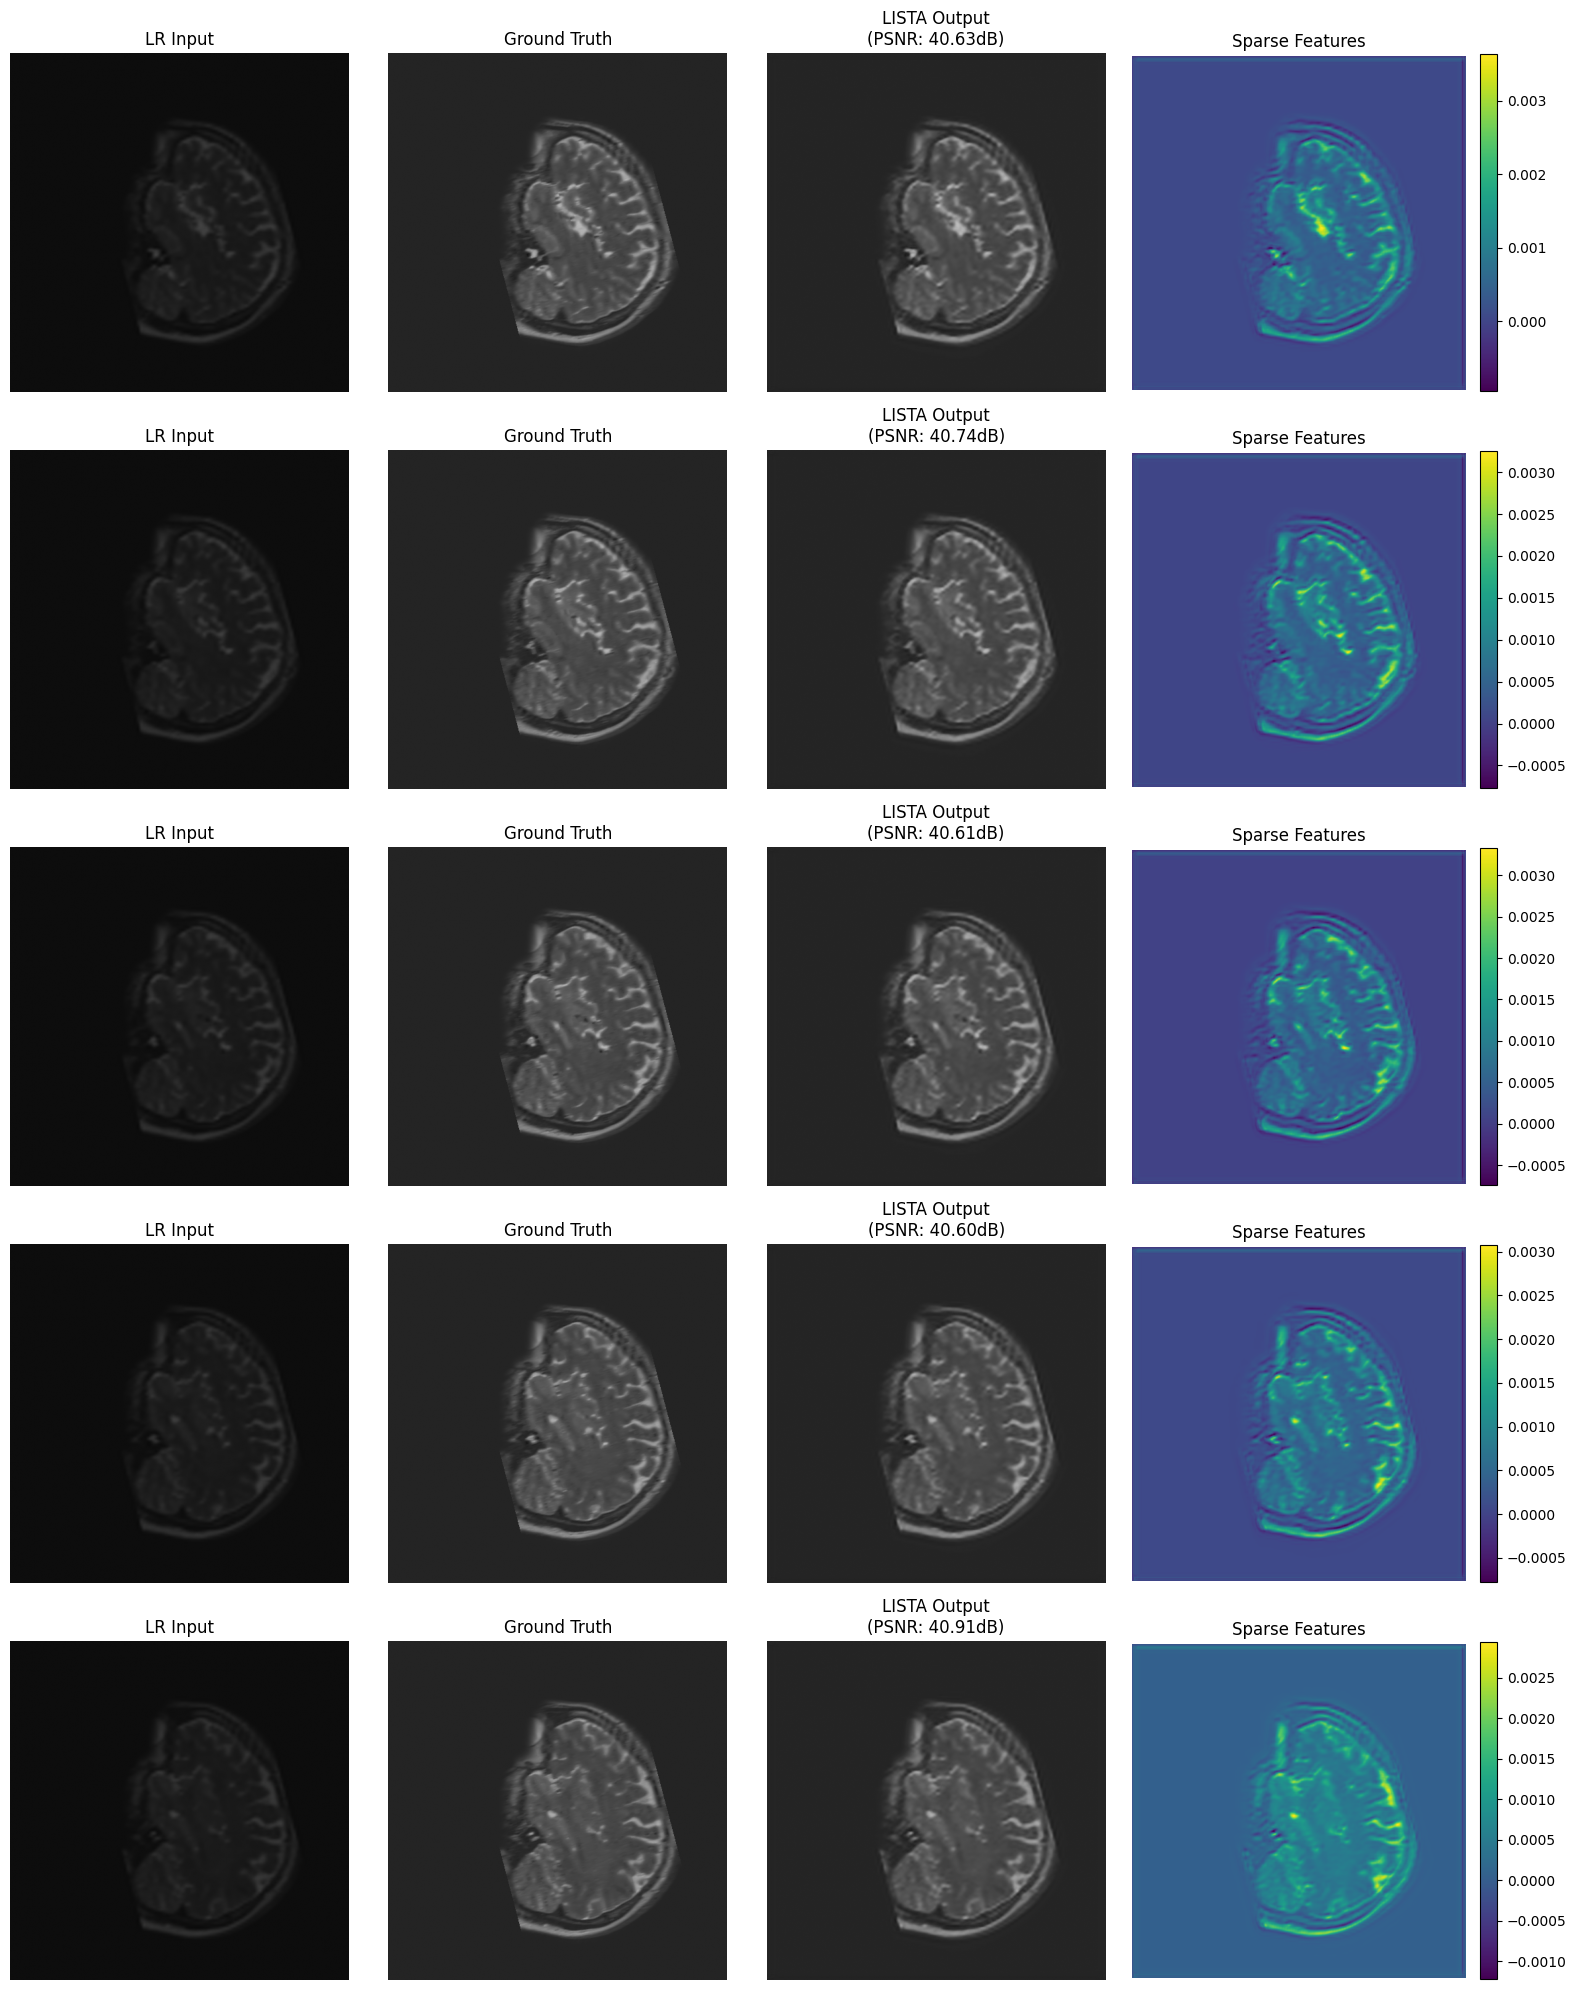

💾 Results saved as 'lista_results.png'

🏁 FINAL SUMMARY:
    🎯 Average PSNR: 39.22dB
    📚 Model: Convolutional LISTA (ACSC)
    ⚙️ Architecture: 3 stages, 100 filters


In [1]:
#!/usr/bin/env python
# coding: utf-8

"""
LISTA (Learned ISTA) Implementation
Based on: "Learning fast approximations of sparse coding" (Gregor & LeCun, 2010)

Εξίσωση από Paper 1 (σελίδα 1, εξίσωση 8):
u^t = φγ(S*u^{t-1} + W*y), u^0 = 0

όπου:
- S = I - (1/L)*D^T*D  
- W = (1/L)*D^T
- φγ: soft thresholding operator
- γ > 0: learnable threshold parameter
"""

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# Χρησιμοποιούμε το ίδιο dataset loader από το LeSITA implementation
#from LESITA_FINAL import MRIDataset, get_dataloader, psnr

# =============================================================================
# MRI DATASET LOADER - EXTRACTED FROM LESITA_FINAL.py
# =============================================================================

import torch
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np

class MRIDataset(Dataset):
    def __init__(self, h5_file, input_key='T2W/LRINPUT', target_key='T2W/TARGET', si_key='T1W/TARGET', augment=False):
        self.h5_file = h5_file
        with h5py.File(h5_file, 'r') as file:
            self.inputs = file[input_key][:]
            self.targets = file[target_key][:]
            self.si = file[si_key][:]

        assert len(self.inputs) == len(self.targets) == len(self.si), "Mismatch in dataset lengths."
        self.augment = augment

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_img = self.inputs[idx].astype(np.float32) / 255.0
        target_img = self.targets[idx].astype(np.float32) / 255.0
        si_img = self.si[idx].astype(np.float32) / 255.0

        input_img = torch.from_numpy(input_img).unsqueeze(0)  # [1, H, W]
        target_img = torch.from_numpy(target_img).unsqueeze(0)
        si_img = torch.from_numpy(si_img).unsqueeze(0)

        if self.augment:
            if torch.rand(1) > 0.5:
                input_img = torch.flip(input_img, [2])
                target_img = torch.flip(target_img, [2])
                si_img = torch.flip(si_img, [2])
            if torch.rand(1) > 0.5:
                input_img = torch.flip(input_img, [1])
                target_img = torch.flip(target_img, [1])
                si_img = torch.flip(si_img, [1])
            if torch.rand(1) > 0.5:
                k = torch.randint(0, 4, (1,))
                input_img = torch.rot90(input_img, k.item(), [1, 2])
                target_img = torch.rot90(target_img, k.item(), [1, 2])
                si_img = torch.rot90(si_img, k.item(), [1, 2])

        return input_img, target_img, si_img

def get_dataloader(h5_file, batch_size=64, shuffle=True, augment=False):
    dataset = MRIDataset(h5_file, augment=augment)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

def psnr(y_true, y_pred, max_val=1.0):
    """
    PSNR metric όπως χρησιμοποιείται στα papers
    """
    mse = torch.mean((y_true - y_pred) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(max_val / torch.sqrt(mse))
# =============================================================================
# SOFT THRESHOLDING OPERATOR (φγ)
# =============================================================================

class SoftThresholding(nn.Module):
    """
    Soft Thresholding Operator από Papers 1 & 2
    
    Εξίσωση (7) από Paper 1: φγ(vi) = sign(vi) * max{0, |vi| − γ}
    Εξίσωση (9) από Paper 2: φγ(vi) = sign(vi) * max{0, |vi| − γ}
    
    Το γ είναι learnable parameter
    """
    def __init__(self, threshold=0.1):
        super(SoftThresholding, self).__init__()
        # Learnable threshold parameter γ
        self.threshold = nn.Parameter(torch.tensor(threshold, dtype=torch.float32))
        
    def forward(self, x):
        """
        Υλοποίηση της εξίσωσης: φγ(vi) = sign(vi) * max{0, |vi| − γ}
        """
        return torch.sign(x) * torch.clamp(torch.abs(x) - self.threshold, min=0.0)

# =============================================================================
# LISTA MODEL 
# =============================================================================

class LISTA(nn.Module):
    """
    LISTA (Learned ISTA) Model από Papers 1 & 2
    
    Εξίσωση (8) από Paper 1: u^t = φγ(S*u^{t-1} + W*y), u^0 = 0
    Εξίσωση (10) από Paper 2: u^t = φγ(S*u^{t-1} + W*y), u^0 = 0
    
    όπου:
    - S ∈ R^{m×m}: learnable matrix (αρχικά S = I - (1/L)*D^T*D)  
    - W ∈ R^{m×n}: learnable matrix (αρχικά W = (1/L)*D^T)
    - γ > 0: learnable threshold parameter
    """
    
    def __init__(self, input_size, sparse_size, num_stages=3, threshold=0.1):
        """
        Args:
            input_size: διάσταση εισόδου (n) - μέγεθος vectorized image
            sparse_size: διάσταση sparse representation (m) 
            num_stages: αριθμός LISTA iterations (T)
            threshold: αρχική τιμή του γ
        """
        super(LISTA, self).__init__()
        
        self.input_size = input_size      # n (από papers)
        self.sparse_size = sparse_size    # m (από papers) 
        self.num_stages = num_stages      # T (από papers)
        
        # Soft thresholding operator με learnable threshold γ
        self.soft_threshold = SoftThresholding(threshold)
        
        # Learnable matrices S και W για κάθε stage
        # Από Paper 1: "The parameters S ∈ R^{m×m}, W ∈ R^{m×n} and γ > 0 of LISTA can be learned from data"
        self.S_layers = nn.ModuleList([
            nn.Linear(sparse_size, sparse_size, bias=False) 
            for _ in range(num_stages)
        ])
        
        self.W_layers = nn.ModuleList([
            nn.Linear(input_size, sparse_size, bias=False)
            for _ in range(num_stages)
        ])
        
    def forward(self, y):
        """
        y: input signal/image (vectorized) - διάσταση [batch_size, input_size]
        
        Returns: sparse codes u - διάσταση [batch_size, sparse_size]
        
        Υλοποιεί την εξίσωση: u^t = φγ(S*u^{t-1} + W*y), u^0 = 0
        """
        batch_size = y.shape[0]
        device = y.device
        
        # Αρχικοποίηση: u^0 = 0 (από Papers)
        u = torch.zeros(batch_size, self.sparse_size, device=device, dtype=y.dtype)
        
        # LISTA iterations για num_stages
        for t in range(self.num_stages):
            # u^t = φγ(S*u^{t-1} + W*y)
            Su = self.S_layers[t](u)          # S * u^{t-1}
            Wy = self.W_layers[t](y)          # W * y
            u = self.soft_threshold(Su + Wy)  # φγ(S*u^{t-1} + W*y)
            
        return u

# =============================================================================
# CONVOLUTIONAL LISTA (ACSC από το Paper 2)
# =============================================================================

class ConvLISTA(nn.Module):
    """
    Convolutional LISTA = ACSC (Approximate Convolutional Sparse Coding)
    
    Εξίσωση (9) από Paper 2: U^t = φγ(U^{t-1} - T ∗ V ∗ U^{t-1} + G ∗ Y)
    Εξίσωση (11) από Paper 2: U^t = φγ(U^{t-1} - T ∗ V ∗ U^{t-1} + G ∗ Y)
    
    όπου:
    - T, V, G: learnable convolutional parameters
    - φγ: soft thresholding operator
    """
    
    def __init__(self, num_stages=3, num_filters=85, kernel_size=7, threshold=0.1):
        super(ConvLISTA, self).__init__()
        
        self.num_stages = num_stages
        
        # Soft thresholding operator με learnable threshold γ
        self.soft_threshold = SoftThresholding(threshold)
        
        # G parameter: μετατρέπει την εικόνα Y (1 channel) σε num_filters channels
        # Από Paper 2: G ∗ Y term
        self.G = nn.Conv2d(1, num_filters, kernel_size, padding=kernel_size//2)
        
        # T parameters για κάθε stage
        # Από Paper 2: T ∗ V ∗ U^{t-1} term
        self.T_layers = nn.ModuleList([
            nn.Conv2d(num_filters, num_filters, kernel_size, padding=kernel_size//2)
            for _ in range(num_stages)
        ])
        
        # V parameters για κάθε stage  
        self.V_layers = nn.ModuleList([
            nn.Conv2d(num_filters, num_filters, kernel_size, padding=kernel_size//2)
            for _ in range(num_stages)
        ])
        
    def forward(self, Y):
        """
        Y: input image - διάσταση [batch_size, 1, H, W]
        
        Returns: sparse feature maps U - διάσταση [batch_size, num_filters, H, W]
        
        Υλοποιεί την εξίσωση: U^t = φγ(U^{t-1} - T ∗ V ∗ U^{t-1} + G ∗ Y)
        """
        batch_size, channels, height, width = Y.shape
        device = Y.device
        
        # Αρχικοποίηση: U^0 = 0 (implied από τα papers)
        U = torch.zeros(batch_size, self.G.out_channels, height, width, 
                       device=device, dtype=Y.dtype)
        
        # Υπολογισμός G ∗ Y μία φορά (δεν αλλάζει στις επαναλήψεις)
        GY = self.G(Y)
        
        # Convolutional LISTA iterations
        for t in range(self.num_stages):
            # T ∗ V ∗ U^{t-1}
            VU = self.V_layers[t](U)
            TVU = self.T_layers[t](VU)
            
            # U^t = φγ(U^{t-1} - T ∗ V ∗ U^{t-1} + G ∗ Y)
            U = self.soft_threshold(U - TVU + GY)
            
        return U

# =============================================================================
# END-TO-END RECONSTRUCTION MODEL
# =============================================================================

class LISTAReconstruction(nn.Module):
    """
    Πλήρες LISTA-based reconstruction model
    
    Αρχιτεκτονική:
    1. Convolutional LISTA (ACSC) για sparse feature extraction
    2. Reconstruction dictionary για HR image synthesis
    """
    
    def __init__(self, num_stages=3, num_filters=85, kernel_size=7, threshold=0.1):
        super(LISTAReconstruction, self).__init__()
        
        # Convolutional LISTA encoder
        self.conv_lista = ConvLISTA(
            num_stages=num_stages,
            num_filters=num_filters, 
            kernel_size=kernel_size,
            threshold=threshold
        )
        
        # Reconstruction dictionary: μετατρέπει sparse features σε HR image
        self.reconstruction_dict = nn.Conv2d(
            num_filters, 1, kernel_size, padding=kernel_size//2
        )
        
        # Αρχικοποίηση παραμέτρων
        self._initialize_weights()
        
    def _initialize_weights(self):
        """
        ΔΙΟΡΘΩΜΕΝΗ Αρχικοποίηση παραμέτρων για καλύτερη convergence
        """
        print("🔧 Initializing LISTA weights (CORRECTED)...")
        
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                # ΔΙΟΡΘΩΣΗ: Xavier/Kaiming initialization αντί για μικρό Gaussian
                # Αυτό βοηθάει με gradient flow και convergence
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
                print(f"    ✓ {name}: Kaiming initialization")
                    
            elif isinstance(module, SoftThresholding):
                # Μικρότερο threshold για καλύτερη αρχή
                with torch.no_grad():
                    module.threshold.data.fill_(0.01)  # ΔΙΟΡΘΩΣΗ: 0.01 αντί για 0.1
                print(f"    ✓ {name}: γ = 0.01")
                
        print("✅ LISTA initialization completed!")
        
    def forward(self, y):
        """
        y: LR input image - διάσταση [batch_size, 1, H, W]
        
        Returns: reconstructed HR image - διάσταση [batch_size, 1, H, W]
        """
        # Step 1: Sparse feature extraction με Convolutional LISTA
        sparse_features = self.conv_lista(y)
        
        # Step 2: Reconstruction με learned dictionary
        reconstructed = self.reconstruction_dict(sparse_features)
        
        return reconstructed, sparse_features

# =============================================================================
# TRAINING SETUP
# =============================================================================

class LISTATrainer:
    """
    Training setup για LISTA model
    """
    
    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device
        
        # Loss function: MSE
        self.criterion = nn.MSELoss()
        
        # ΔΙΟΡΘΩΣΗ: Μεγαλύτερο learning rate για καλύτερη convergence
        # Όταν τα weights είναι μικρά, χρειάζεται πιο aggressive learning
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-4)  # ΑΛΛΑΓΗ: 1e-3 αντί για 1e-4
        
        # ΠΡΟΣΘΗΚΗ: Learning rate scheduler για καλύτερη σταθερότητα
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='max', factor=0.5, patience=5
        )
        
    def train_epoch(self, dataloader):
        """Training για ένα epoch"""
        self.model.train()
        total_loss = 0.0
        total_psnr = 0.0
        
        for batch_idx, (x_lr, x_hr, x_si) in enumerate(dataloader):
            # Μεταφορά στη GPU/CPU
            x_lr = x_lr.to(self.device)  # LR input
            x_hr = x_hr.to(self.device)  # HR target (ground truth)
            # Σημείωση: x_si (side information) δεν χρησιμοποιείται στο LISTA
            
            # Forward pass
            self.optimizer.zero_grad()
            pred_hr, sparse_features = self.model(x_lr)
            
            # Loss computation
            loss = self.criterion(pred_hr, x_hr)
            
            # Backward pass
            loss.backward()
            self.optimizer.step()
            
            # Metrics
            total_loss += loss.item()
            
            with torch.no_grad():
                batch_psnr = psnr(x_hr, pred_hr)
                total_psnr += batch_psnr.item() if torch.isfinite(batch_psnr) else 0.0
        
        avg_loss = total_loss / len(dataloader)
        avg_psnr = total_psnr / len(dataloader)
        
        return avg_loss, avg_psnr
    
    def validate(self, dataloader):
        """Validation loop"""
        self.model.eval()
        total_loss = 0.0
        total_psnr = 0.0
        
        with torch.no_grad():
            for x_lr, x_hr, x_si in dataloader:
                x_lr = x_lr.to(self.device)
                x_hr = x_hr.to(self.device)
                
                pred_hr, _ = self.model(x_lr)
                loss = self.criterion(pred_hr, x_hr)
                
                total_loss += loss.item()
                batch_psnr = psnr(x_hr, pred_hr)
                total_psnr += batch_psnr.item() if torch.isfinite(batch_psnr) else 0.0
        
        avg_loss = total_loss / len(dataloader)
        avg_psnr = total_psnr / len(dataloader)
        
        return avg_loss, avg_psnr
    
    def train(self, train_loader, val_loader, epochs=100, checkpoint_path="lista_best.pt"):
        """Πλήρης training loop με ΔΙΟΡΘΩΣΕΙΣ"""
        print("🚀 Starting LISTA Training (CORRECTED)")
        print(f"📊 Training setup:")
        print(f"   - Model: Convolutional LISTA (ACSC)")
        print(f"   - Loss: MSE")
        print(f"   - Optimizer: Adam, lr=1e-4 (INCREASED)")  # ΔΙΟΡΘΩΣΗ
        print(f"   - Scheduler: ReduceLROnPlateau")  # ΠΡΟΣΘΗΚΗ
        print(f"   - Epochs: {epochs}")
        print(f"   - Device: {self.device}")
        print("-" * 60)
        
        best_psnr = 0.0
        patience_counter = 0
        max_patience = 10  # ΠΡΟΣΘΗΚΗ: Early stopping
        
        for epoch in range(epochs):
            # Training
            train_loss, train_psnr = self.train_epoch(train_loader)
            
            # Validation
            val_loss, val_psnr = self.validate(val_loader)
            
            # ΠΡΟΣΘΗΚΗ: Learning rate scheduling
            self.scheduler.step(val_psnr)
            
            # Logging
            print(f"📈 Epoch [{epoch+1:3d}/{epochs}] | "
                  f"Train: Loss={train_loss:.6f}, PSNR={train_psnr:.2f}dB | "
                  f"Val: Loss={val_loss:.6f}, PSNR={val_psnr:.2f}dB")
            
            # Save best model
            if val_psnr > best_psnr:
                best_psnr = val_psnr
                patience_counter = 0  # Reset patience
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'best_psnr': best_psnr,
                    'train_loss': train_loss,
                    'val_loss': val_loss
                }, checkpoint_path)
                print(f"💾 Saved best model (PSNR: {best_psnr:.2f}dB)")
            else:
                patience_counter += 1
                
            # ΠΡΟΣΘΗΚΗ: Early stopping
            if patience_counter >= max_patience:
                print(f"🛑 Early stopping after {patience_counter} epochs without improvement")
                break
        
        print("✅ Training completed!")
        print(f"🏆 Best validation PSNR: {best_psnr:.2f}dB")
        
        return best_psnr

# =============================================================================
# TESTING & VISUALIZATION
# =============================================================================

def test_lista_model(model_path, test_loader, device):
    """Testing και evaluation του LISTA model"""
    
    print("🧪 Starting LISTA Model Testing")
    print("=" * 50)
    
    # Φόρτωση του καλύτερου μοντέλου
    model = LISTAReconstruction(
        num_stages=3,        # 3 unfolding stages
        num_filters=100,      # 64 sparse feature maps
        kernel_size=7,       # 7x7 kernels
        threshold=0.1        # Initial γ = 0.1
    )
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    print(f"📁 Loaded model from: {model_path}")
    print(f"🏆 Best training PSNR: {checkpoint['best_psnr']:.2f}dB")
    print("-" * 50)
    
    # Testing metrics
    total_psnr = 0.0
    total_samples = 0
    results = []
    
    with torch.no_grad():
        for batch_idx, (x_lr, x_hr, x_si) in enumerate(test_loader):
            x_lr = x_lr.to(device)  # LR input
            x_hr = x_hr.to(device)  # HR ground truth
            
            # Inference
            pred_hr, sparse_features = model(x_lr)
            
            # PSNR για κάθε εικόνα στο batch
            for i in range(x_lr.shape[0]):
                img_psnr = psnr(x_hr[i:i+1], pred_hr[i:i+1]).item()
                total_psnr += img_psnr
                total_samples += 1
                
                # Αποθήκευση για visualization (πρώτες 5 εικόνες)
                if len(results) < 5:
                    results.append({
                        'lr': x_lr[i].cpu(),
                        'hr_gt': x_hr[i].cpu(), 
                        'hr_pred': pred_hr[i].cpu(),
                        'sparse_features': sparse_features[i].cpu(),
                        'psnr': img_psnr
                    })
            
            if batch_idx % 5 == 0:
                print(f"   📊 Processed batch {batch_idx+1}/{len(test_loader)}")
    
    # Τελικά αποτελέσματα
    avg_psnr = total_psnr / total_samples
    print(f"\n🎯 ΤΕΛΙΚΑ ΑΠΟΤΕΛΕΣΜΑΤΑ:")
    print(f"    📊 Average PSNR: {avg_psnr:.2f}dB")
    print(f"    📈 Total samples: {total_samples}")
    
    return results, avg_psnr

def visualize_lista_results(results):
    """Visualization των αποτελεσμάτων του LISTA"""
    
    print("🎨 Creating LISTA visualization...")
    
    fig, axes = plt.subplots(len(results), 4, figsize=(16, 4*len(results)))
    if len(results) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, result in enumerate(results):
        # Μετατροπή σε numpy arrays
        lr = result['lr'][0].numpy()
        hr_gt = result['hr_gt'][0].numpy() 
        hr_pred = result['hr_pred'][0].detach().numpy()
        sparse_features = result['sparse_features'].mean(dim=0).numpy()  # Mean across channels
        
        # Error map
        error_map = np.abs(hr_gt - hr_pred)
        
        # Plots
        axes[idx, 0].imshow(lr, cmap='gray', vmin=0, vmax=1)
        axes[idx, 0].set_title(f'LR Input', fontsize=12)
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(hr_gt, cmap='gray', vmin=0, vmax=1)
        axes[idx, 1].set_title(f'Ground Truth', fontsize=12)
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(hr_pred, cmap='gray', vmin=0, vmax=1)
        axes[idx, 2].set_title(f'LISTA Output\n(PSNR: {result["psnr"]:.2f}dB)', fontsize=12)
        axes[idx, 2].axis('off')
        
        # Sparse features visualization
        im = axes[idx, 3].imshow(sparse_features, cmap='viridis')
        axes[idx, 3].set_title(f'Sparse Features', fontsize=12)
        axes[idx, 3].axis('off')
        plt.colorbar(im, ax=axes[idx, 3], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.savefig('lista_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("💾 Results saved as 'lista_results.png'")

# =============================================================================
# MAIN PIPELINE FUNCTION
# =============================================================================

def main_lista_pipeline(epochs=50):
    """Πλήρης LISTA training και testing pipeline"""
    
    print("🔬 LISTA TRAINING & TESTING PIPELINE")
    print("📚 Based on: Learning fast approximations of sparse coding (Gregor & LeCun)")
    print("="*70)
    
    try:
        # Setup device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"💻 Using device: {device}")
        
        # Data paths (χρησιμοποιούμε τα ίδια με το LeSITA)
        train_path = r"D:\Diploma Thesis\MICCAI DATASETS\LRx4_MStrain_flair_t1w_t2w_44_unnormalized.h5py"
        test_path = r"D:\Diploma Thesis\MICCAI DATASETS\LRx4_MStest_flair_t1w_t2w_unnormalized.h5py"
        
        # Data loaders
        print("\n📂 Creating data loaders...")
        train_loader = get_dataloader(train_path, batch_size=32, shuffle=True, augment=True)
        test_loader = get_dataloader(test_path, batch_size=8, shuffle=False, augment=False)
        
        print(f"    📊 Train samples: {len(train_loader.dataset)}")
        print(f"    📊 Test samples: {len(test_loader.dataset)}")
        
        # Model creation
        print("\n🏗️ Creating LISTA model...")
        model = LISTAReconstruction(
            num_stages=3,        # 3 unfolding stages
            num_filters=100,      # 64 sparse feature maps
            kernel_size=7,       # 7x7 kernels
            threshold=0.1        # Initial γ = 0.1
        )
        
        # Model info
        total_params = sum(p.numel() for p in model.parameters())
        print(f"    📊 Total parameters: {total_params:,}")
        print(f"    💾 Model size: {total_params * 4 / 1e6:.1f}MB")
        
        # Training
        print(f"\n{'='*70}")
        trainer = LISTATrainer(model, device)
        best_psnr = trainer.train(train_loader, test_loader, epochs=epochs, 
                                 checkpoint_path="lista_best.pt")
        
        # Testing
        print(f"\n{'='*70}")
        results, avg_psnr = test_lista_model("lista_best.pt", test_loader, device)
        
        # Visualization
        print(f"\n{'='*70}")
        visualize_lista_results(results)
        
        # Final summary
        print(f"\n🏁 FINAL SUMMARY:")
        print(f"    🎯 Average PSNR: {avg_psnr:.2f}dB")
        print(f"    📚 Model: Convolutional LISTA (ACSC)")
        print(f"    ⚙️ Architecture: {model.conv_lista.num_stages} stages, {model.conv_lista.G.out_channels} filters")
        
        return model, avg_psnr
        
    except Exception as e:
        print(f"❌ Error: {e}")
        print(f"🔧 Make sure your .h5 files exist and paths are correct")

# =============================================================================
# QUICK START
# =============================================================================

if __name__ == "__main__":
    print("🚀 LISTA (Learned ISTA) Implementation")
    print("📖 Based on Gregor & LeCun papers")
    print("-" * 50)
    
    print("Choose training option:")
    print("1. Quick test (10 epochs)")
    print("2. Standard training (50 epochs)")
    print("3. Extended training (100 epochs)")
    
    choice = input("Enter choice (1/2/3): ").strip()
    
    if choice == "1":
        main_lista_pipeline(epochs=10)
    elif choice == "2":  
        main_lista_pipeline(epochs=50)
    elif choice == "3":
        main_lista_pipeline(epochs=100)
    else:
        print("🔄 Running default (50 epochs)...")
        main_lista_pipeline(epochs=50)

In [2]:
#BEST CONV LISTA 